# Проект для интернет-магазина "В один клик"

Интернет-магазину "В один клик" нужно удержать активность клиентов с помощью персонализированных предложений.  
**Цель:** разработать модель, которая предскажет вероятность снижения покупательской активности, предложить как повысить покупательскую активность.   
**План исследования:**
1. Загрузка и знакомство с данными.
2. Предобработка данных, работа с пропусками и дубликатами.
3. Исследовательский анализ данных, предварительный отбор клиентов.
4. Объединение таблиц.
5. Корреляционный анализ признаков в датасете.
6. Использование пайплайнов, обучение моделей, выбор лучшей.
7.  Анализ важности признаков.
8.  Сегментация покупателей.
9.  Общий вывод.

# Описание данных

**Данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении -** `market_file.csv`
+ `id` - номер покупателя в корпоративной базе данных;
+ `Покупательская активность` - рассчитанный класс покупательской активности (целевой признак);
+ `Тип сервиса` - уровень сервиса, премиум или стандарт;
+ `Разрешить сообщать` - информация о том, можно ли присылать покупателю дополнительные предложения о товаре;
+ `Маркет_актив_6_мес` - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев(число рассылок, звонков и тд.);
+ `Маркет_актив_тек_мес` - значение маркетинговых коммуникаций компании в текущем месяце;
+ `Длительность` - сколько дней прошло с момента регистрации пользователя на сайте;
+ `Акционные_покупки` - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев;
+ `Популярная_категория` - самая популярная категория товаров у покупателя за последние 6 месяцев;
+ `Средний_просмотр_категорий_за_визит` -   сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца;
+ `Неоплаченные_продукты_штук_квартал` - oбщее число неоплаченных товаров в корзине за последние 3 месяца;
+ `Ошибка_сервиса` - число сбоев, которые коснулись покупателя во время посещения сайта;
+ `Страниц_за_визит` - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

**Данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом-** `market_money.csv`
+ `id` - номер покупателя в корпоративной базе данных;
+ `Период` - название периода, во время которого зафиксирована выручка;
+ `Выручка` - сумма выручки за период.

**Данные о времени (в минутах), которое покупатель провёл на сайте в течение периода -** `market_time.csv`
+ `id` - номер покупателя в корпоративной базе данных;
+ `Период` - название периода, во время которого зафиксировано общее время;
+ `минут` - значение времени, проведённого на сайте, в минутах.

**Данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю-** `money.csv`
+ `id` - номер покупателя в корпоративной базе данных;
+ `Прибыль` - значение прибыли.


# Шаг 1

#### 1.1. Загрузка и первичное знакомство с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
!pip install phik -q
!pip install optuna-integration -q
!pip install shap -q
import phik
import optuna
import shap

from phik.report import plot_correlation_matrix
from phik import phik_matrix

from optuna import distributions
from optuna.integration import OptunaSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, make_scorer, roc_curve
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [2]:
!pip list

Package                           Version
--------------------------------- --------------
alembic                           1.14.0
anyio                             4.4.0
appnope                           0.1.4
argon2-cffi                       23.1.0
argon2-cffi-bindings              21.2.0
arrow                             1.3.0
asttokens                         2.4.1
async-lru                         2.0.4
attrs                             23.2.0
Babel                             2.14.0
beautifulsoup4                    4.9.3
bleach                            6.1.0
Brotli                            1.1.0
cached-property                   1.5.2
certifi                           2024.8.30
cffi                              1.16.0
charset-normalizer                3.3.2
click                             8.1.7
cloudpickle                       3.1.0
colorlog                          6.9.0
comm                              0.2.2
contourpy                         1.3.0
cycler             

In [3]:
try:
    file = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/6 спринт/market_file.csv')
    m_money = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/6 спринт/market_money.csv')
    time = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/6 спринт/market_time.csv')
    money = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/6 спринт/money.csv', sep=';', decimal=',')
except:
    file = pd.read_csv('/datasets/market_file.csv')
    m_money = pd.read_csv('/datasets/market_money.csv')
    time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv',  sep=';', decimal=',')
    
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)

print(display(file.head(5)))
print(display(m_money.head(5)))
print(display(time.head(5)))
print(display(money.head(5)))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.400,5,121,0.000,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.400,4,819,0.750,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.900,3,539,0.140,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.200,5,896,0.990,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.100,3,1064,0.940,Товары для детей,3,2,3,2


None


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.000
1,215348,текущий_месяц,"3,293.100"
2,215348,предыдущий_месяц,0.000
3,215349,препредыдущий_месяц,"4,472.000"
4,215349,текущий_месяц,"4,971.600"


None


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


None


,id,Прибыль
0,215348,0.980
1,215349,4.160
2,215350,3.130
3,215351,4.870
4,215352,4.210


None


#### 1.2. Изучение данных

In [4]:
print(file.info(), m_money.info(), time.info(), money.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

#### Промежуточный вывод

**Цель:** загрузить данные и ознакомиться с общей информацией датафреймов.  
**Результаты:**
1) Установили объем данных: 
- `file` 12 столбцов, 1300 строк.
- `m_money` 3 столбца, 3900 строк.
- `time` 3 столбцa, 2600 строк.
- `money` 3 столбца, 1300 строк.

2) Обнаружено, что числа с плавающей точной в некоторых датафреймах разделени ".", в некоторых ",". Так же опечатка в слове "стндарт". Исправим данные ошибки в пункте предобработки данных.

2) Пропусков не обнаружено, данные полные.

# Шаг 2

#### 2.1. Предобработка данных

Менять название столбцов не будем, но изменимм знаки пробелов на нижнее подчеркивание для однородности. Внесем изменеия в типы данных.

In [5]:
file.columns = file.columns.str.replace(' ', '_')
file.columns = file.columns.str.lower()

In [6]:
print(file.dtypes)

id                                       int64
покупательская_активность               object
тип_сервиса                             object
разрешить_сообщать                      object
маркет_актив_6_мес                     float64
маркет_актив_тек_мес                     int64
длительность                             int64
акционные_покупки                      float64
популярная_категория                    object
средний_просмотр_категорий_за_визит      int64
неоплаченные_продукты_штук_квартал       int64
ошибка_сервиса                           int64
страниц_за_визит                         int64
dtype: object


In [7]:
m_money.columns = m_money.columns.str.lower()
print(m_money.dtypes)

id           int64
период      object
выручка    float64
dtype: object


In [8]:
time.columns = time.columns.str.lower()
print(time.dtypes)

id         int64
период    object
минут      int64
dtype: object


In [9]:
money.columns = money.columns.str.lower()
print(money.dtypes)

id           int64
прибыль    float64
dtype: object


Приведем типы данных к корректному виду.

In [10]:
# file
file['покупательская_активность'] = file['покупательская_активность'].astype('category') 
file['тип_сервиса'] = file['тип_сервиса'].astype('category') 
file['разрешить_сообщать'] = file['разрешить_сообщать'].astype('category') 
file['популярная_категория'] = file['популярная_категория'].astype('category') 
# m_money
m_money['период'] = m_money['период'].astype('category') 
# time
time['период'] = time['период'].astype('category') 

Проверим на явные дубликаты.

In [11]:
print(f'Количество выявленных явных дубликатов в данных о поведении покупателей на сайте: {file.duplicated().sum()}')
print(f'Количество выявленных явных дубликатов в данных о выручке: {m_money.duplicated().sum()}')
print(f'Количество выявленных явных дубликатов в данных о времени проведения на сайте: {time.duplicated().sum()}')
print(f'Количество выявленных явных дубликатов в данных о среднемесячной прибыли: {money.duplicated().sum()}')

Количество выявленных явных дубликатов в данных о поведении покупателей на сайте: 0
Количество выявленных явных дубликатов в данных о выручке: 0
Количество выявленных явных дубликатов в данных о времени проведения на сайте: 0
Количество выявленных явных дубликатов в данных о среднемесячной прибыли: 0


Явные дубликаты не обнаружены, проверим неявные.

In [12]:
columns_to_print = [
    'покупательская_активность',
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория',
    'период'
]

for column in columns_to_print:
    if column in file.columns:
        unique_values = file[column].unique().tolist()
        print(f'Уникальные значения в {column}: {unique_values}')
    elif column in m_money.columns:
        unique_values = m_money[column].unique().tolist()
        print(f'Уникальные значения в {column}: {unique_values}')

print(time['период'].unique().tolist())

Уникальные значения в покупательская_активность: ['Снизилась', 'Прежний уровень']
Уникальные значения в тип_сервиса: ['премиум', 'стандартт', 'стандарт']
Уникальные значения в разрешить_сообщать: ['да', 'нет']
Уникальные значения в популярная_категория: ['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары', 'Техника для красоты и здоровья', 'Кухонная посуда', 'Мелкая бытовая техника и электроника']
Уникальные значения в период: ['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц']
['текущий_месяц', 'предыдцщий_месяц']


Обнаружены неявные дубликаты в колнке "тип сервиса", исправим и в колонке "период". Так же опечатка в "популярная_категория".

In [13]:
file['тип_сервиса'] = file['тип_сервиса'].replace('стандартт', 'стандарт')
file['популярная_категория'] = file['популярная_категория'].replace('Косметика и аксесуары', 'Косметика и аксессуары')
time['период'] = time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

print(file['тип_сервиса'].unique().tolist(), file['популярная_категория'].unique().tolist(), time['период'].unique().tolist())

['премиум', 'стандарт'] ['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары', 'Техника для красоты и здоровья', 'Кухонная посуда', 'Мелкая бытовая техника и электроника'] ['текущий_месяц', 'предыдущий_месяц']


####  Промежуточный вывод

**Цель:** выполнить предобработку данных.  
**Задачи:**
1. Проверка и исправление типов данных.
2. Выявление и обработка явных и неявных дубликатов.

**Результаты**

1) Проверка и исправление типов данных:
- Исправлены название столбцов `file`, знаки пробела заменены на нижнее подчеркивание.
- Во всех категориальных столбцах тип данных изменен на `category`.

2) Выявление и обработка явных и неявных дубликатов:
- Явные дубликаты не выявлены.
- Выявлены неявные дубликаты в категориальных столбцe "Тип сервиса" датафрейма `file`, "стандартт"-"стандарт", "аксессуары"-"аксессуары" и в столбце "Период" датафрейма `time`, "предыдцщий_месяц"-"предыдущий_месяц".


# Шаг 3

#### 3.1. Исследовательский анализ данных

Используем функции для исследования данных.

In [14]:
def categorical_attributes(df, attribute, title, hue=None):
    '''
    Plots for categorical attributes with an optional hue for segmentation
        Parameters:
            df: Dataframe
            attribute: Column with attribute
            title: Title of graphs
            hue: Optional; column for target segmentation
            
    Returns:
        Series: number of unique values
        plot: pie chart and countplot
    '''
    counts = df[attribute].value_counts(ascending=False)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    wedges, texts, autotexts = ax1.pie(counts, labels=counts.index, autopct='%1.1f%%',
                                       startangle=90, colors=sns.color_palette('afmhot_r', len(counts)))
    plt.setp(autotexts, size=12, weight='bold', color='black')
    plt.setp(texts, size=12)
    ax1.set_title(title, fontsize=16, fontweight='bold')

    sns.countplot(x=attribute, data=df, palette='afmhot_r', ax=ax2, hue=hue)
    ax2.set_title(title, fontsize=16, fontweight='bold')
    ax2.set_xlabel(attribute)
    ax2.set_ylabel('Частота')
    ax2.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()
    sns.set(rc={
    'figure.figsize': (10, 7.5),
    'axes.labelsize': 12,  
    'xtick.labelsize': 10, 
    'ytick.labelsize': 10,  
    })
    print(counts)

def quantitative_attributes(df, attribute, title, hue=None, bins=20):
    '''
    Plots for quantitative attributes
        Parameters:
            df: DataFrame
            attribute: Column with attribute
            title: Title of graphs
            hue: Optional, column for target segmentation
            bins: Number of bins for the histogram
            
    Returns:
        None
    '''
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    if hue and hue in df.columns:
        sns.histplot(df, x=attribute, hue=hue, kde=True, bins=bins, ax=ax[0], multiple="dodge", palette="Set2")
    else:
        sns.histplot(df[attribute], kde=True, bins=bins, ax=ax[0], palette="Set2")

    ax[0].set_title('Гистограмма', fontsize=18)
    ax[0].set_xlabel(title, fontsize=15)
    
    sns.boxplot(x=attribute, data=df, ax=ax[1], palette="Set2", hue=hue)
    ax[1].set_title('Ящик с усами', fontsize=18)
    ax[1].set_xlabel(title, fontsize=15)
    
    sns.set(rc={'figure.figsize': (10, 7.5),
    'axes.labelsize': 12,  
    'xtick.labelsize': 10, 
    'ytick.labelsize': 10,
    })
    fig.suptitle(title, fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print(df[attribute].describe().T)
    

##### **Исследование категориальных признаков**

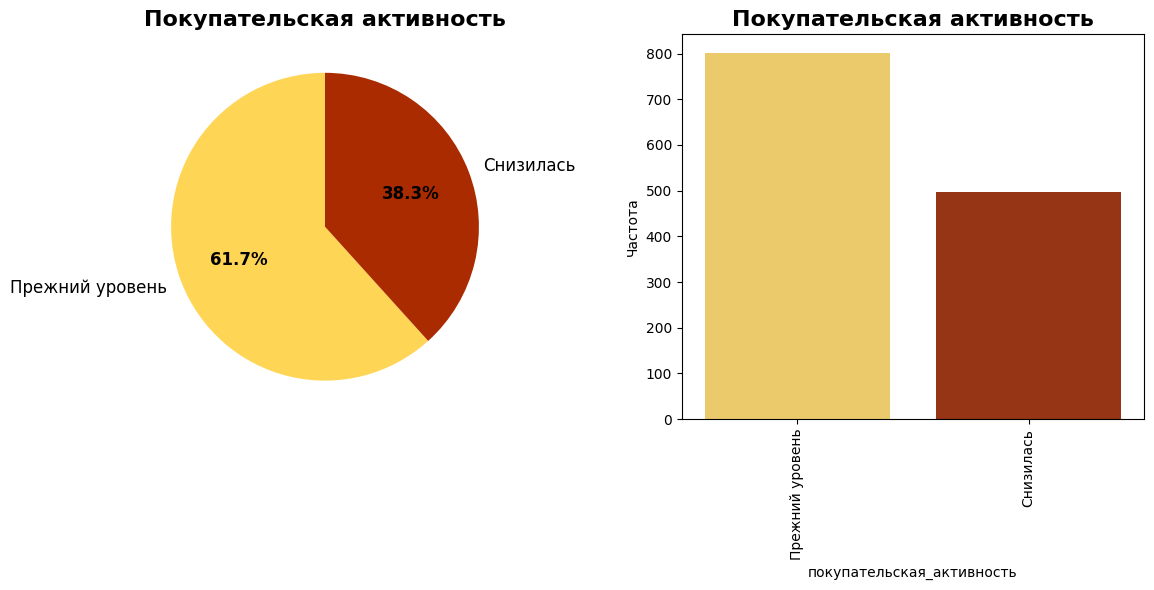

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64


In [15]:
categorical_attributes(file, 'покупательская_активность', 'Покупательская активность')

Покупательская активность снизилась у 38,3% покупателей.

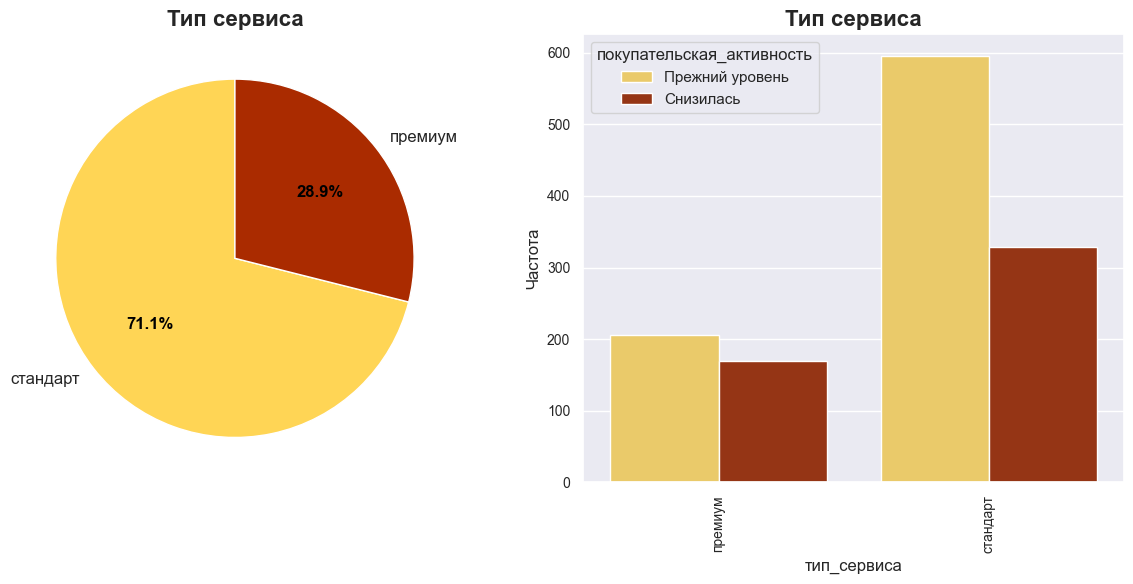

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64


In [16]:
categorical_attributes(file, 'тип_сервиса', 'Тип сервиса', 'покупательская_активность')

Премиум сервис у 28,9% покупателей. Из пользователей со стандартной подпиской почти вполовину больше пользователей с прежним уровнем покупательской активности.

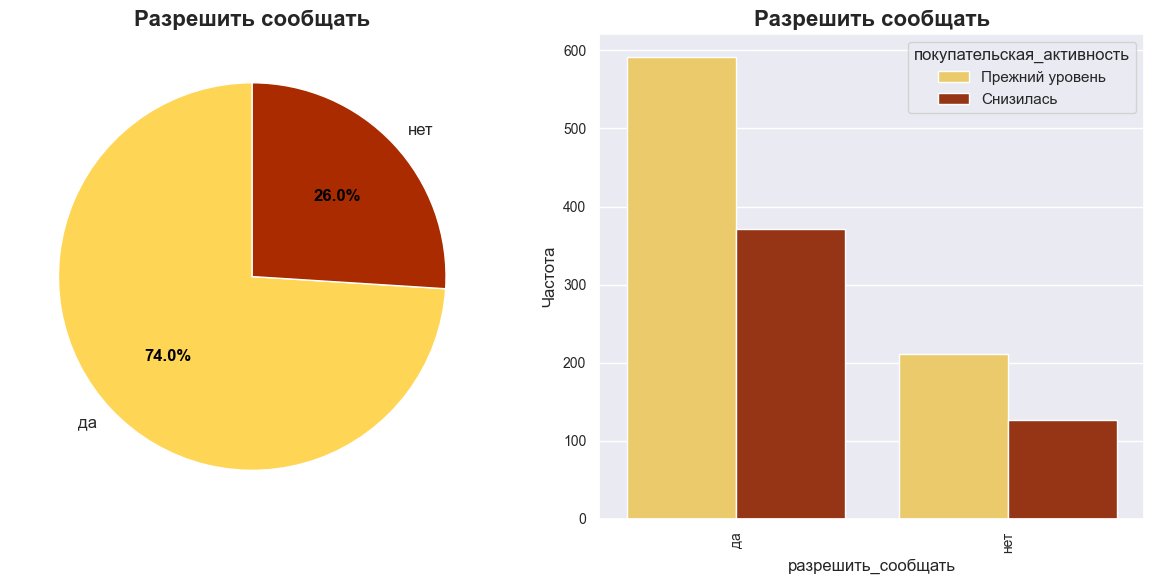

да     962
нет    338
Name: разрешить_сообщать, dtype: int64


In [17]:
categorical_attributes(file, 'разрешить_сообщать', 'Разрешить сообщать', 'покупательская_активность')

74% покупателей разрешают сообщать им дополнительнительные предложения о товаре.

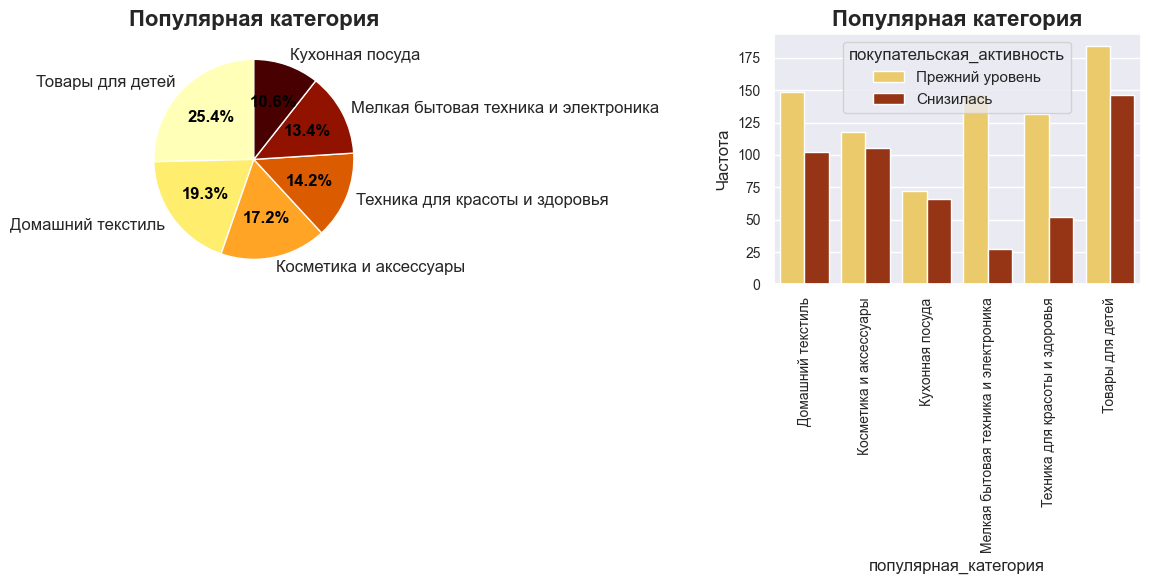

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксессуары                  223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64


In [18]:
categorical_attributes(file, 'популярная_категория', 'Популярная категория', 'покупательская_активность')

Самая популярная категория "Товары для детей", следом "Домашний текстиль", наименее популярная категория "Кухонная посуда". Мелкую бытовую технику и товары для хдоровья покупает наименьшее количество пользователей со сниженной покупательской активностью.

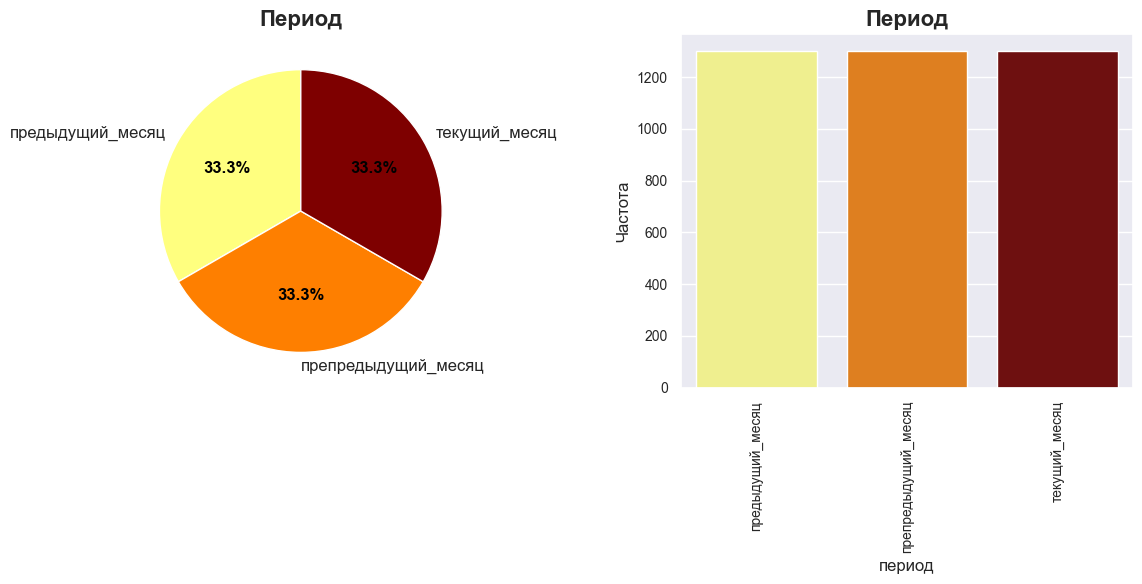

предыдущий_месяц       1300
препредыдущий_месяц    1300
текущий_месяц          1300
Name: период, dtype: int64


In [19]:
categorical_attributes(m_money, 'период', 'Период')


Данные о периоде выручки распределены равномерно по трем последним месяцам.

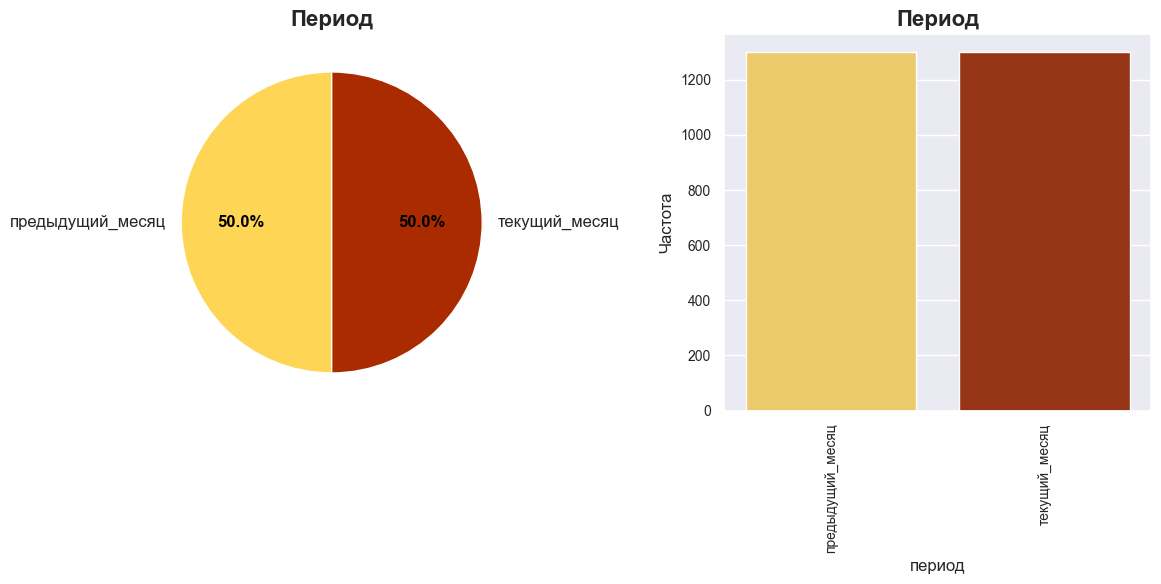

предыдущий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64


In [20]:
categorical_attributes(time, 'период', 'Период')

Данные о времени проведенном на сайте распределены равномерно по последним двум месяцам.

#### **Исследование количественных признаков**

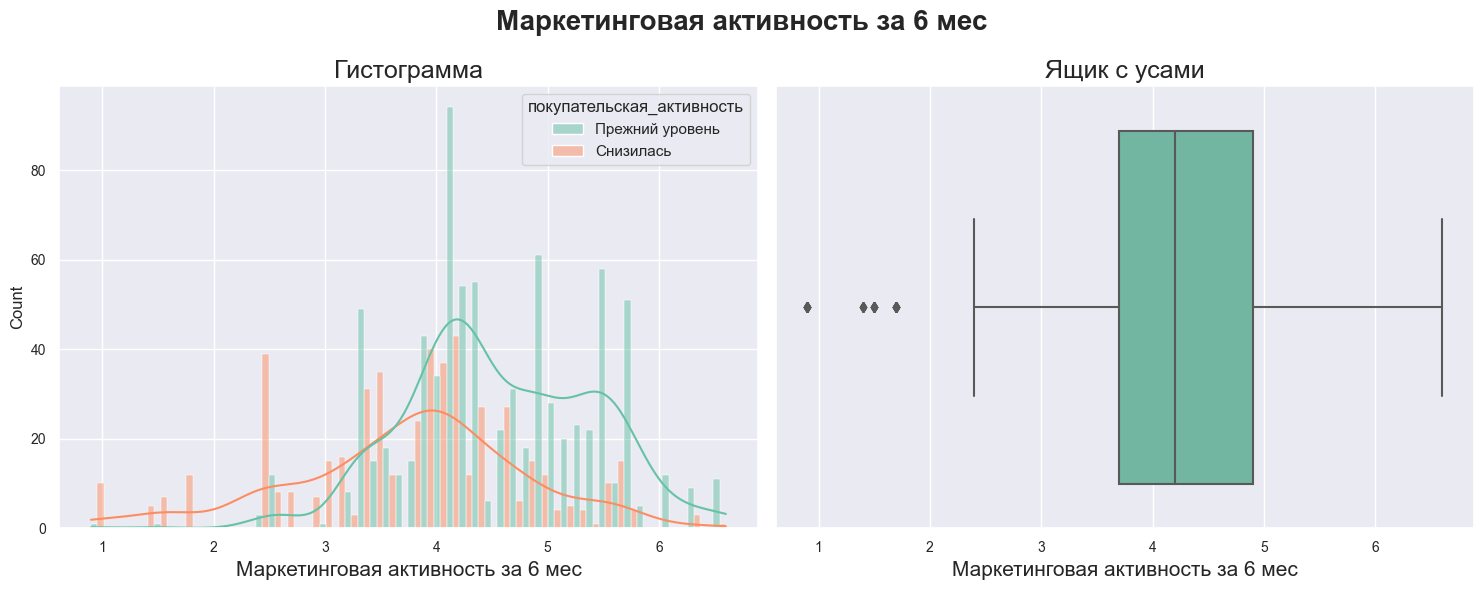

count   1,300.000
mean        4.254
std         1.015
min         0.900
25%         3.700
50%         4.200
75%         4.900
max         6.600
Name: маркет_актив_6_мес, dtype: float64


In [21]:
quantitative_attributes(file,'маркет_актив_6_мес','Маркетинговая активность за 6 мес', 'покупательская_активность', bins=50)

Маркетинговая активность за 6 месяцев была более активной для пользователей с прежним уровнем покупательской активности.

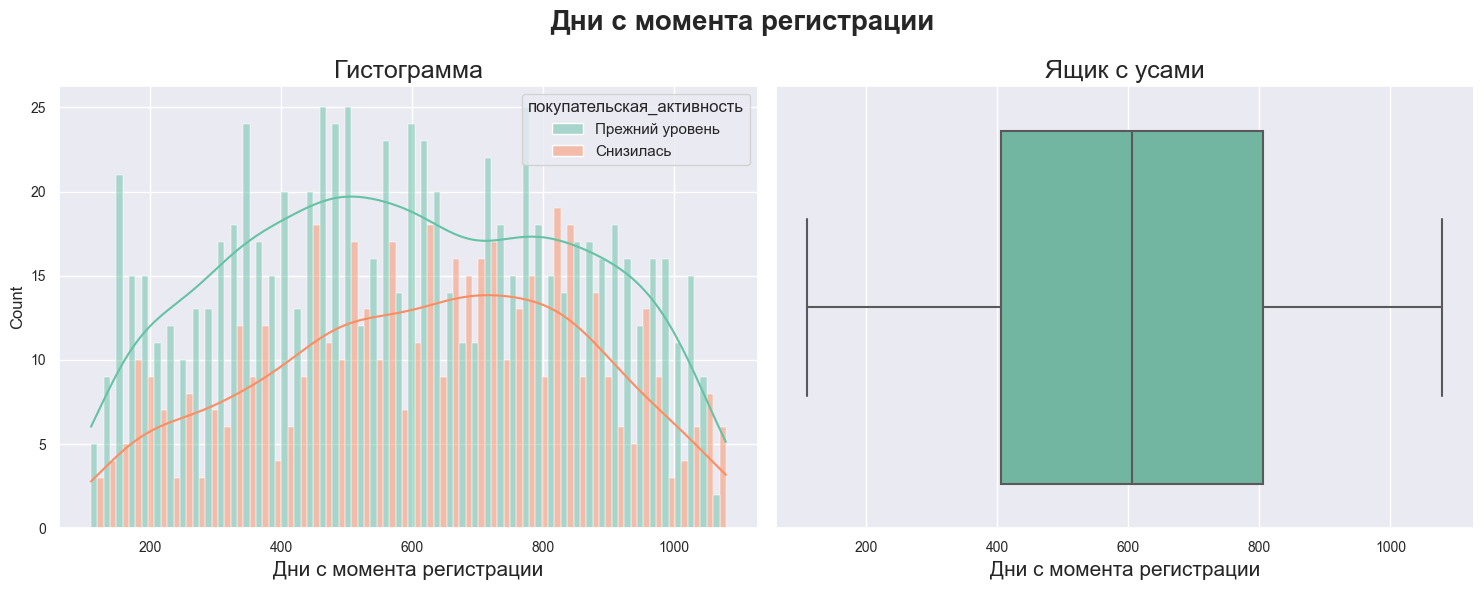

count   1,300.000
mean      601.898
std       249.856
min       110.000
25%       405.500
50%       606.000
75%       806.000
max     1,079.000
Name: длительность, dtype: float64


In [22]:
quantitative_attributes(file,'длительность','Дни с момента регистрации', 'покупательская_активность', bins=50)

Максимальное окличество дней с момента регистрации - 1079. Среднее и медианное значение почти совпадают - 601 и 606 дней.

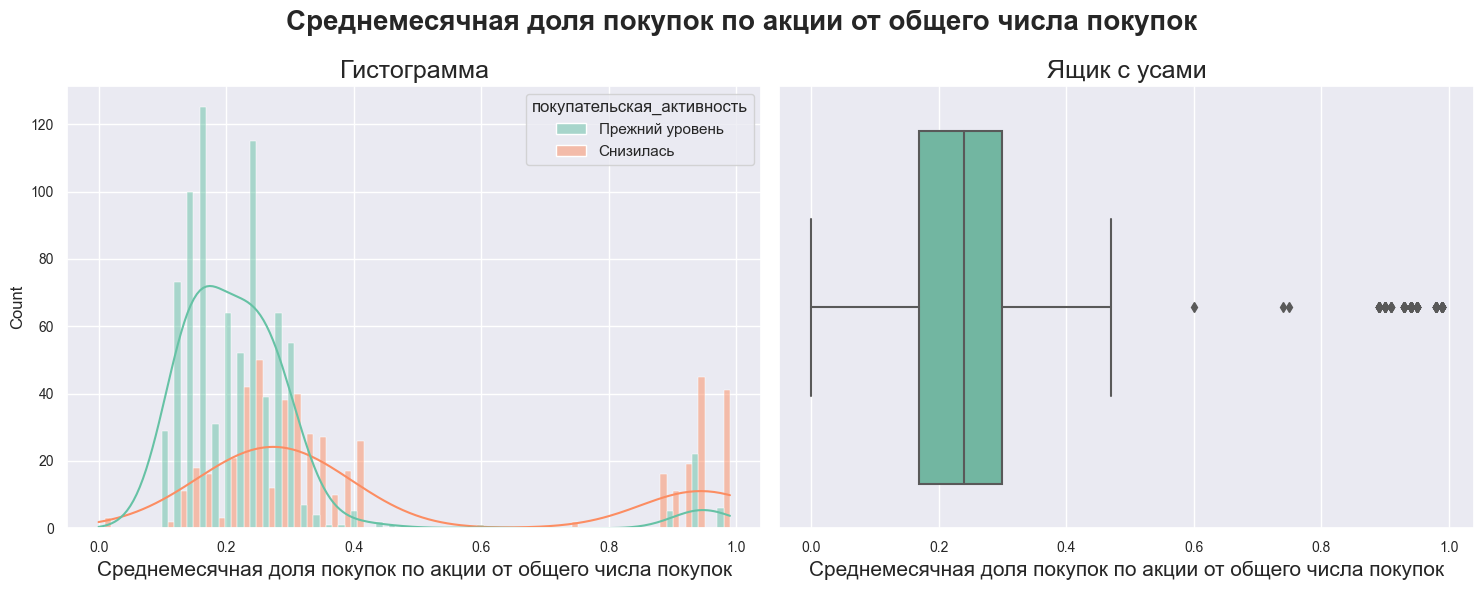

count   1,300.000
mean        0.320
std         0.250
min         0.000
25%         0.170
50%         0.240
75%         0.300
max         0.990
Name: акционные_покупки, dtype: float64


In [23]:
quantitative_attributes(file,'акционные_покупки','Среднемесячная доля покупок по акции от общего числа покупок', 'покупательская_активность', bins=50)

Основная доля акционных покупок от 0.1 до 0.4. Но присутсвует ряд значений на высоких показателях, которые язик с усами определяет как выбросы. Думаю, что данные значения нельзя считать выбросами, так как вполне реально, что есть покупатели, которые совершают покупки только по акциям.

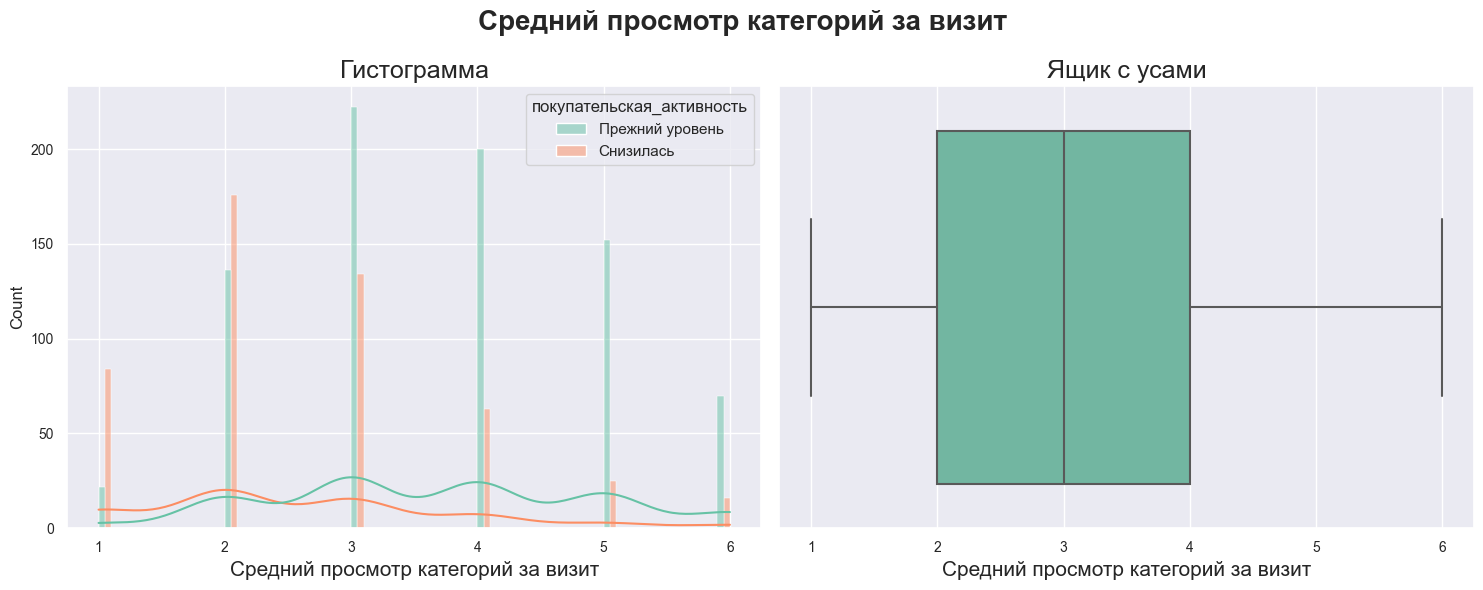

count   1,300.000
mean        3.270
std         1.355
min         1.000
25%         2.000
50%         3.000
75%         4.000
max         6.000
Name: средний_просмотр_категорий_за_визит, dtype: float64


In [24]:
quantitative_attributes(file,'средний_просмотр_категорий_за_визит','Средний просмотр категорий за визит', 'покупательская_активность', bins=50)

В среднем пользователи за один визит смотрят товары из 3 категорий, максимуально из 6. Покупатели со сниженной покупательской актинвостью смотрят меньше категорий за визит.

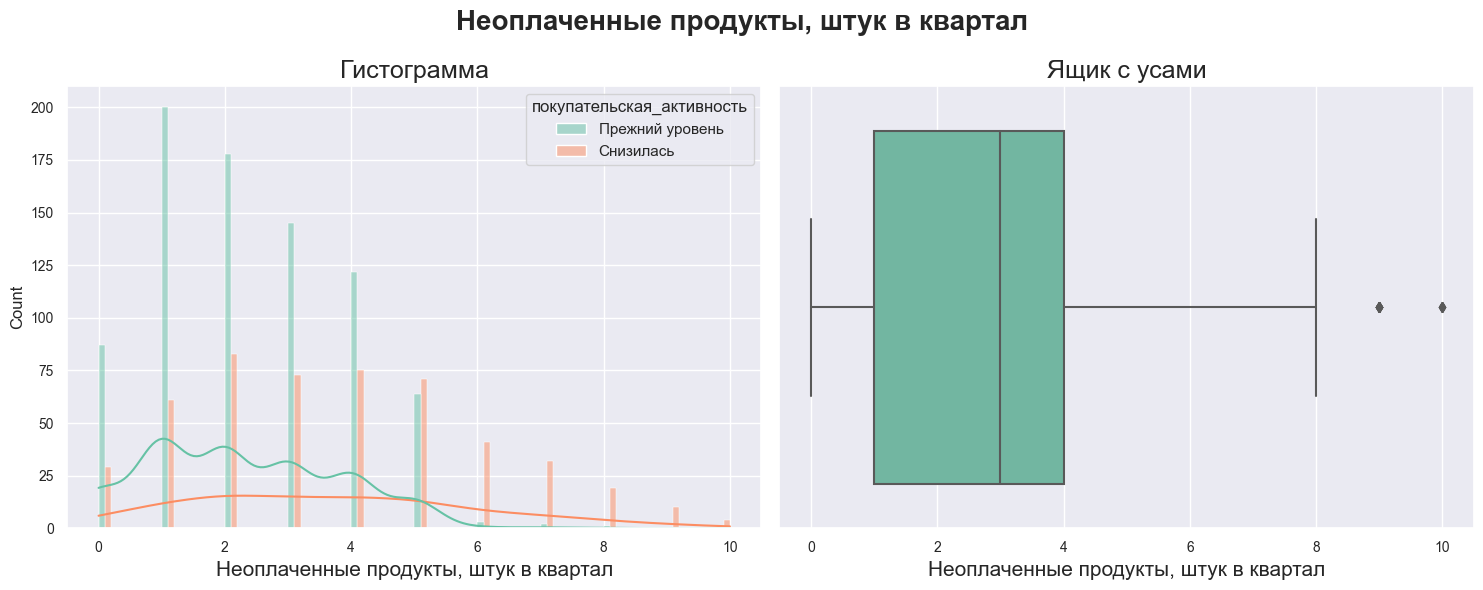

count   1,300.000
mean        2.840
std         1.971
min         0.000
25%         1.000
50%         3.000
75%         4.000
max        10.000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


In [25]:
quantitative_attributes(file,'неоплаченные_продукты_штук_квартал','Неоплаченные продукты, штук в квартал', 'покупательская_активность', bins=50)

Покупатели в среднем хранят неоплаченными 3 продукта в корзите за квартал. Максимально - 10. Покупатели со сниженной покупательской актиновстью хранят больше неоплаченных продуктов в корзине.

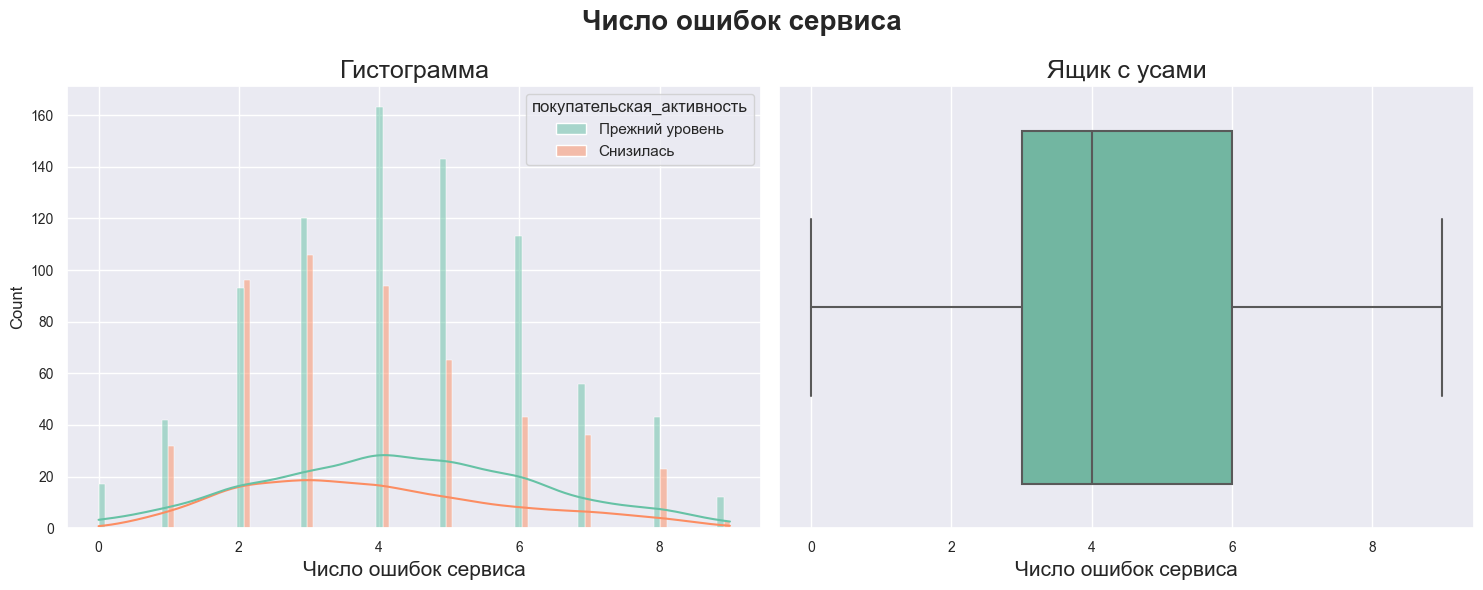

count   1,300.000
mean        4.185
std         1.955
min         0.000
25%         3.000
50%         4.000
75%         6.000
max         9.000
Name: ошибка_сервиса, dtype: float64


In [26]:
quantitative_attributes(file,'ошибка_сервиса','Число ошибок сервиса', 'покупательская_активность', bins=50)

В среднем за время посещения сайта регистрируется 4 сбоя, максимальное количество - 9. 

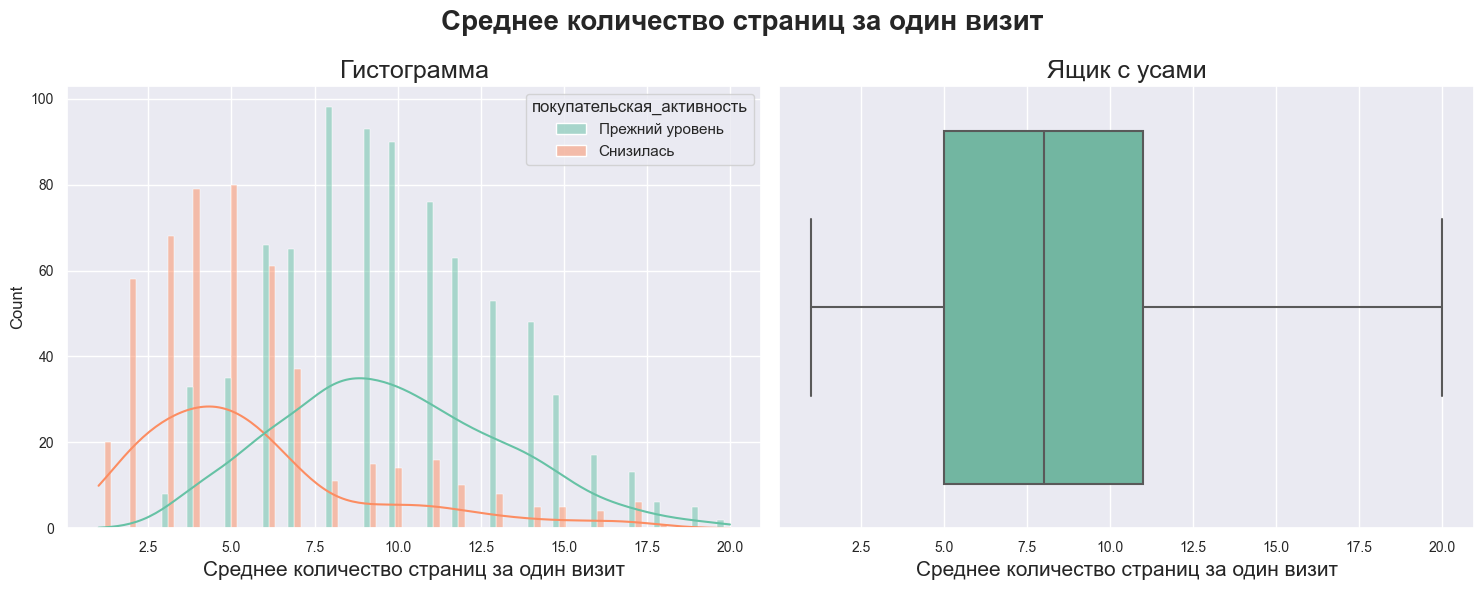

count   1,300.000
mean        8.177
std         3.978
min         1.000
25%         5.000
50%         8.000
75%        11.000
max        20.000
Name: страниц_за_визит, dtype: float64


In [27]:
quantitative_attributes(file,'страниц_за_визит','Среднее количество страниц за один визит', 'покупательская_активность', bins=50)

Среднее колиечество просмотренных страниц за визит - 8. Итого от 1 до 20. Покупатели со сниженной покупательской актиновстью меньше посещают в среднем страниц за один визит.

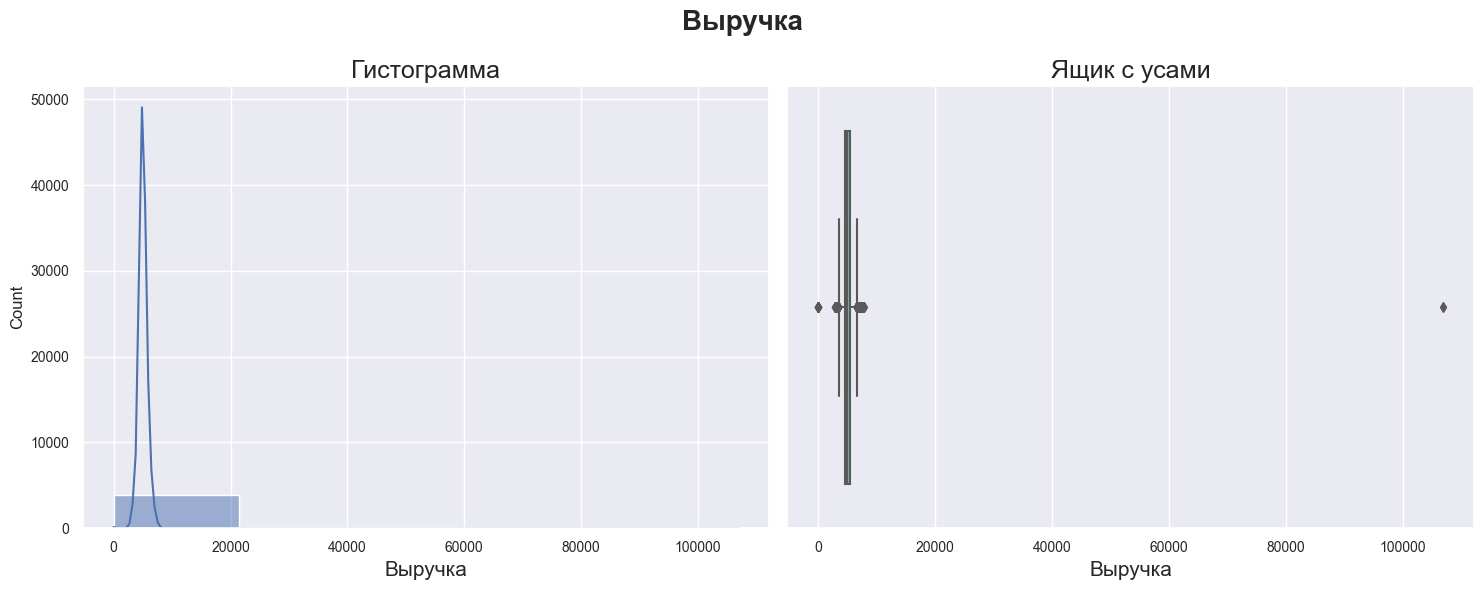

count     3,900.000
mean      5,025.696
std       1,777.704
min           0.000
25%       4,590.150
50%       4,957.500
75%       5,363.000
max     106,862.200
Name: выручка, dtype: float64


In [28]:
quantitative_attributes(m_money,'выручка','Выручка', bins=5)

Выведем отдельно строки с выручкой равной 0.

In [29]:
m_money.query('выручка < 100')

,id,период,выручка
0,215348,препредыдущий_месяц,0.000
2,215348,предыдущий_месяц,0.000
28,215357,препредыдущий_месяц,0.000
29,215357,предыдущий_месяц,0.000
34,215359,предыдущий_месяц,0.000
35,215359,препредыдущий_месяц,0.000


Данных с выручкой равной 0 мало, можно пожертвовать ими и удалить. Теперь посмотрим на столбец с выручкой более 100000.

In [30]:
print(display(m_money.query('выручка > 100000')))

,id,период,выручка
98,215380,текущий_месяц,"106,862.200"


None


In [31]:
m_money.shape

(3900, 3)

Скорее всего эти данные ошибочны, удалим.

In [32]:
m_money = m_money.query('выручка <= 100000')
m_money = m_money.query('выручка > 100')
m_money.shape

(3893, 3)

Размер датафрейма `m_money` уменьшился на 7 строк, удаление данных прошло корректно. Изучим выручку в формате без выбросов.

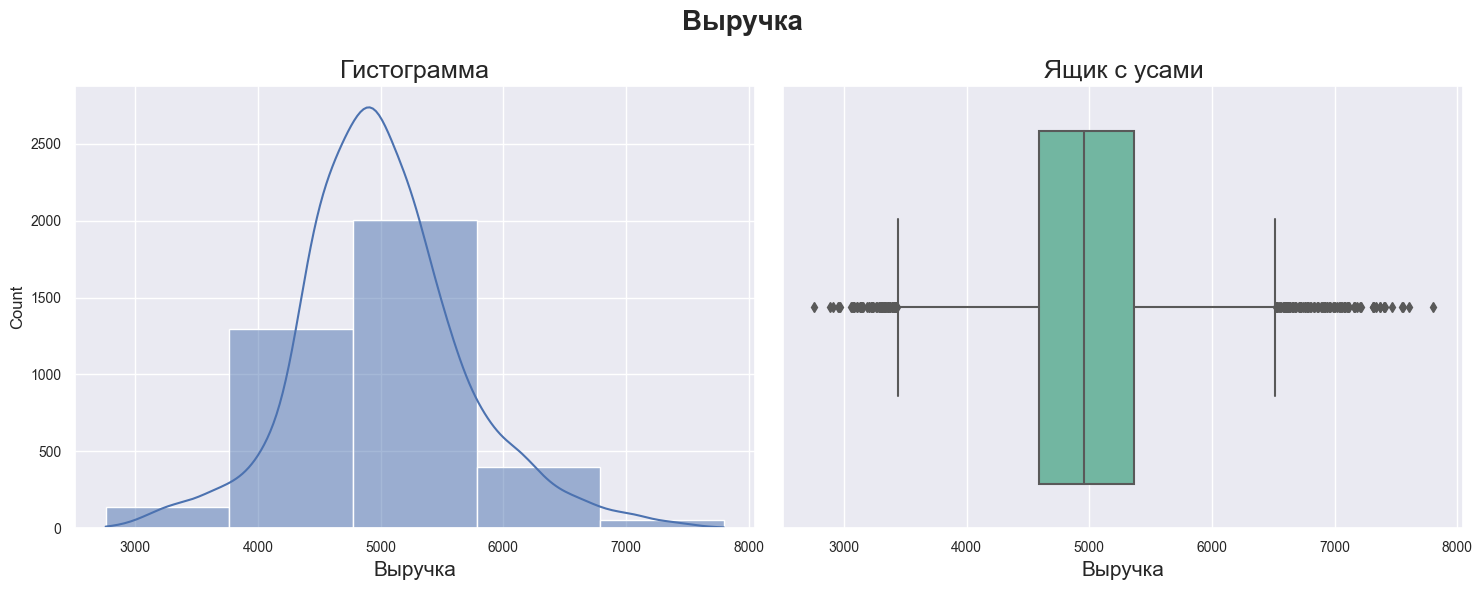

count   3,893.000
mean    5,007.283
std       679.725
min     2,758.700
25%     4,592.000
50%     4,959.000
75%     5,363.000
max     7,799.400
Name: выручка, dtype: float64


In [33]:
quantitative_attributes(m_money,'выручка','Выручка', bins=5)


Выручка в среднем составляет 5000, распределение близко к нормальному. Ящик с усами указывает на большое количество выбросов, но цифры вполне корректные, оставим как есть.

Изучим распределение выручки и минут по временым периодам.

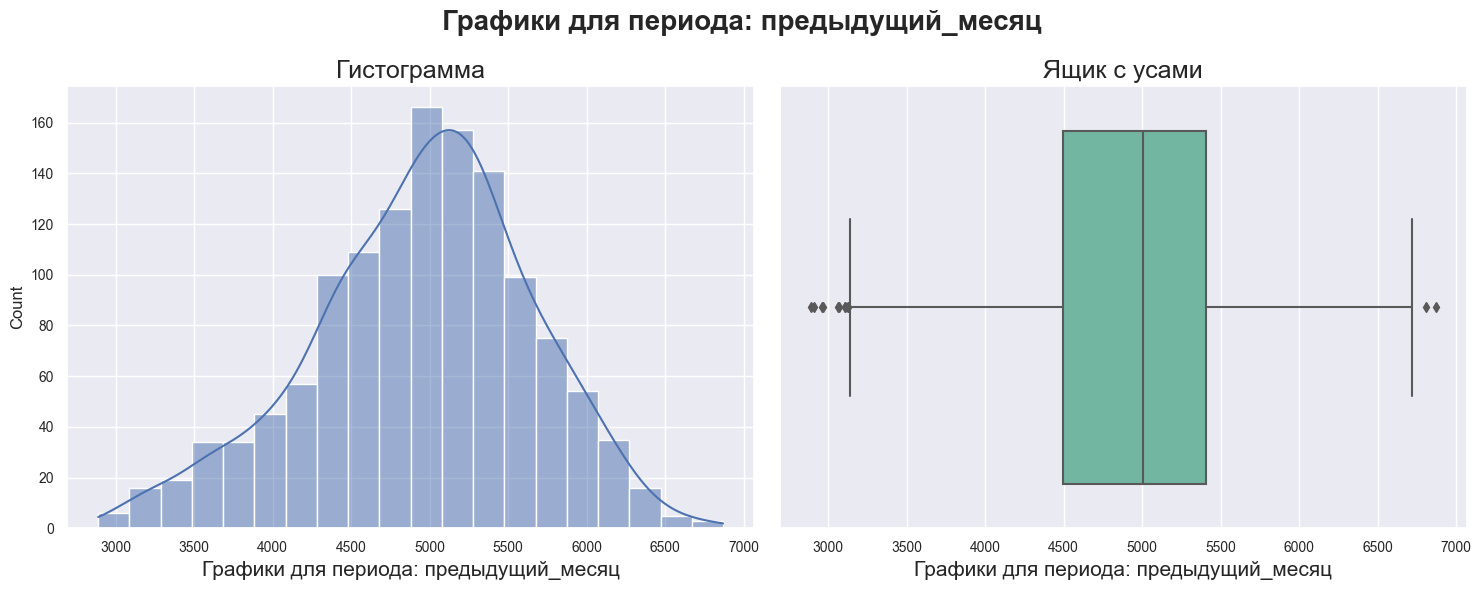

count   1,297.000
mean    4,948.340
std       701.229
min     2,890.000
25%     4,498.500
50%     5,005.500
75%     5,409.000
max     6,869.500
Name: выручка, dtype: float64


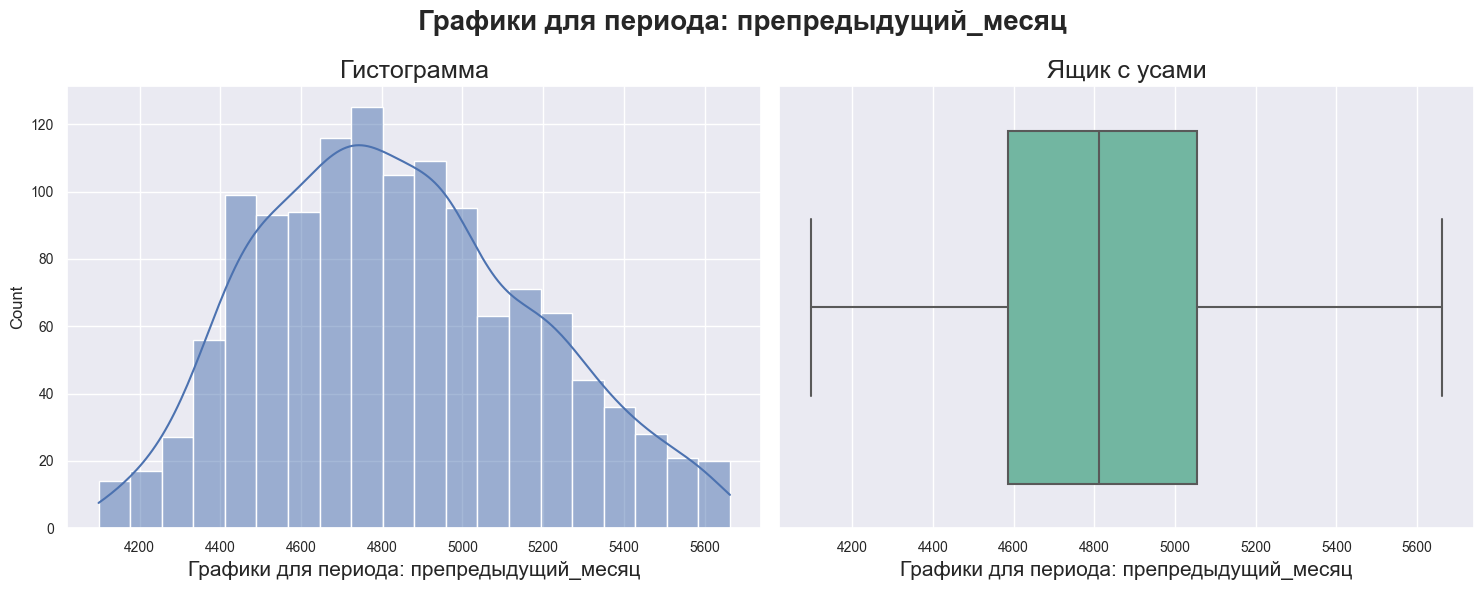

count   1,297.000
mean    4,836.368
std       333.439
min     4,098.000
25%     4,585.000
50%     4,812.000
75%     5,055.000
max     5,663.000
Name: выручка, dtype: float64


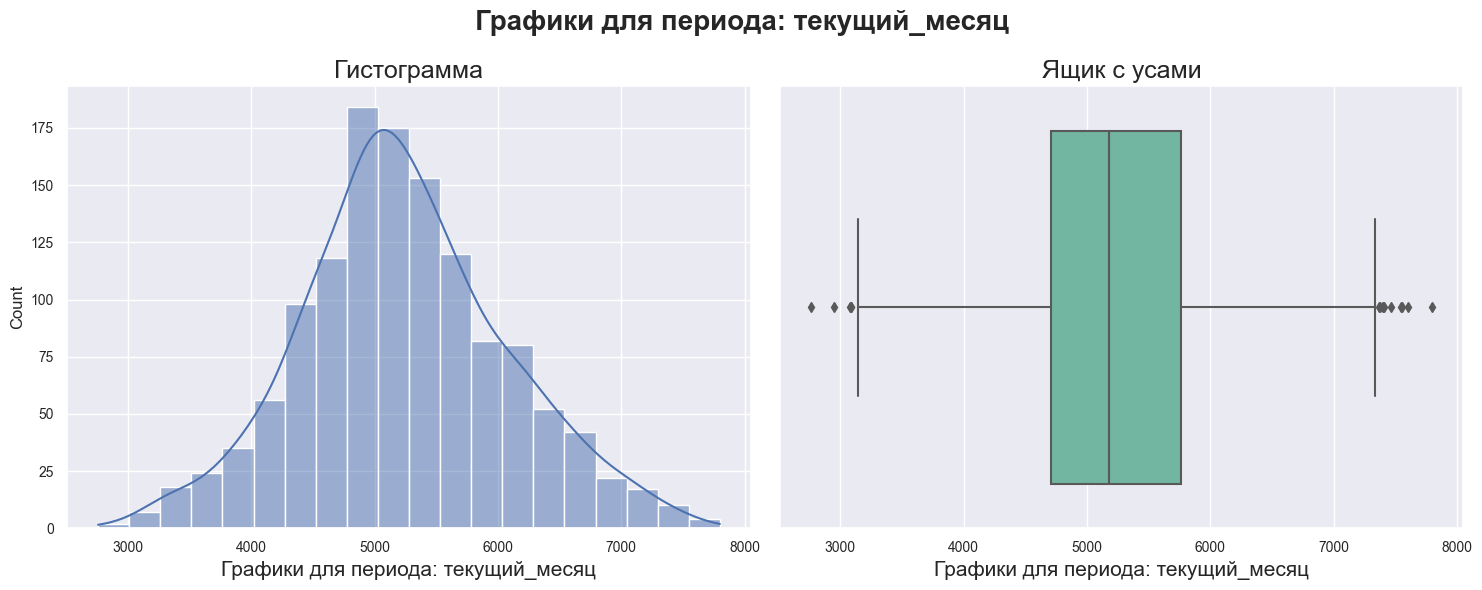

count   1,299.000
mean    5,236.787
std       835.475
min     2,758.700
25%     4,705.500
50%     5,179.600
75%     5,759.950
max     7,799.400
Name: выручка, dtype: float64


In [34]:
grouped = m_money.groupby('период')['выручка'].sum().reset_index()

for period in grouped['период'].unique():
    period_data = m_money[m_money['период'] == period]
    quantitative_attributes(period_data, 'выручка', f'Графики для периода: {period}')

Текущий месяц принес максимальную выручку. Распределение выручки во все периоды приближено к нормальному. Выбросы по ящику с усами наблюдаются в предудыщем и текущем месяце в обе стороны. Значения выбросов вполне адекватны, поэтому за выбросы их не считаем.

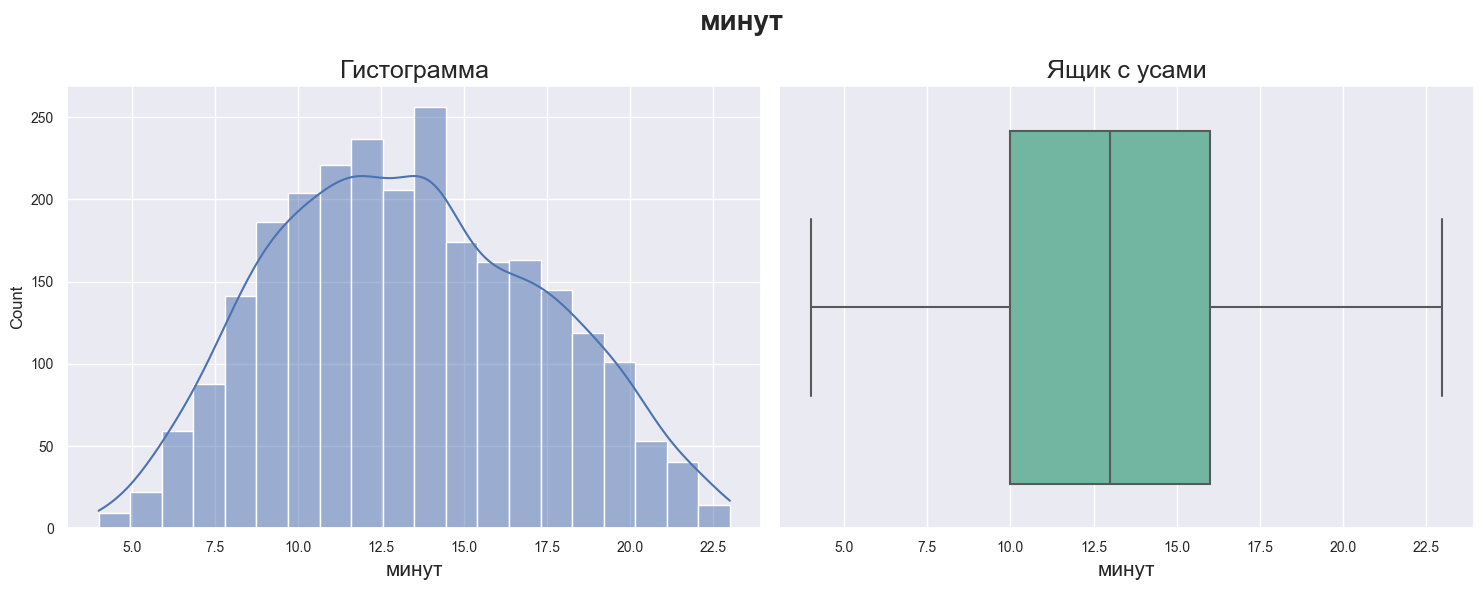

count   2,600.000
mean       13.336
std         4.080
min         4.000
25%        10.000
50%        13.000
75%        16.000
max        23.000
Name: минут, dtype: float64


In [35]:
quantitative_attributes(time, 'минут', 'минут')

Максимальное проведенное время на сайте 23 минуты, минимальное 4, среднее и медианное 13 минут. Выбросов нет. Изучим распределение минут по периодам.

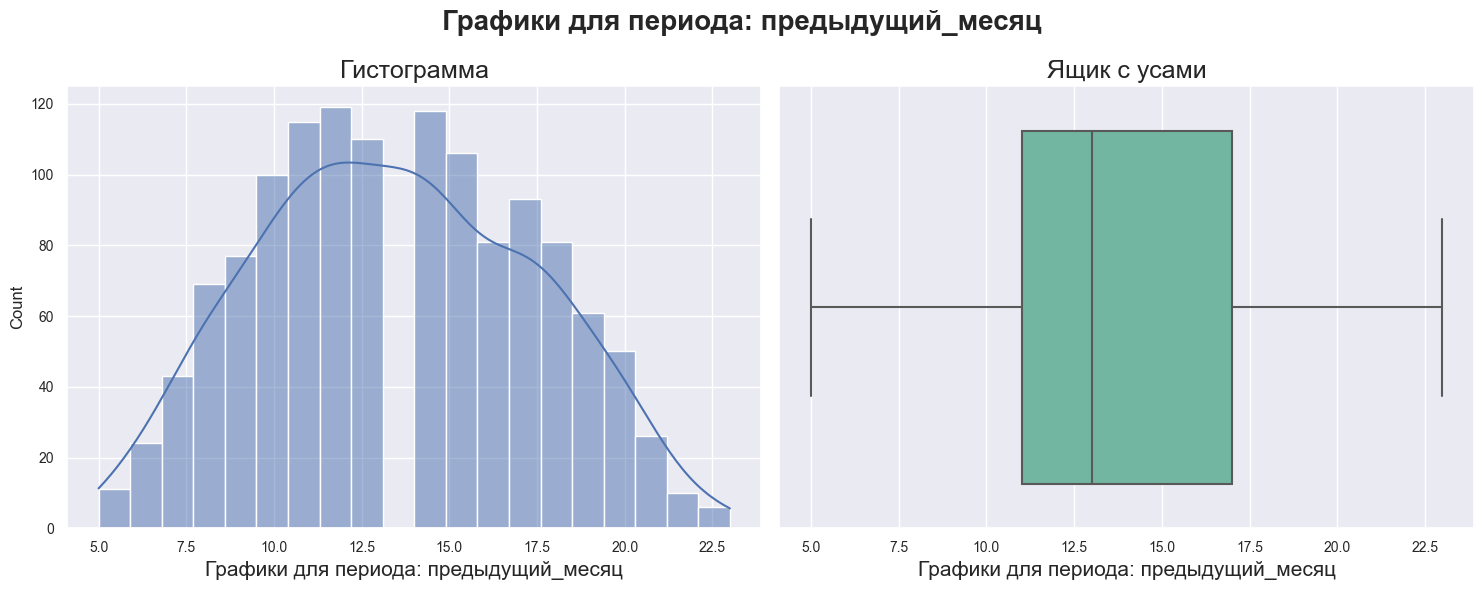

count   1,300.000
mean       13.468
std         3.932
min         5.000
25%        11.000
50%        13.000
75%        17.000
max        23.000
Name: минут, dtype: float64


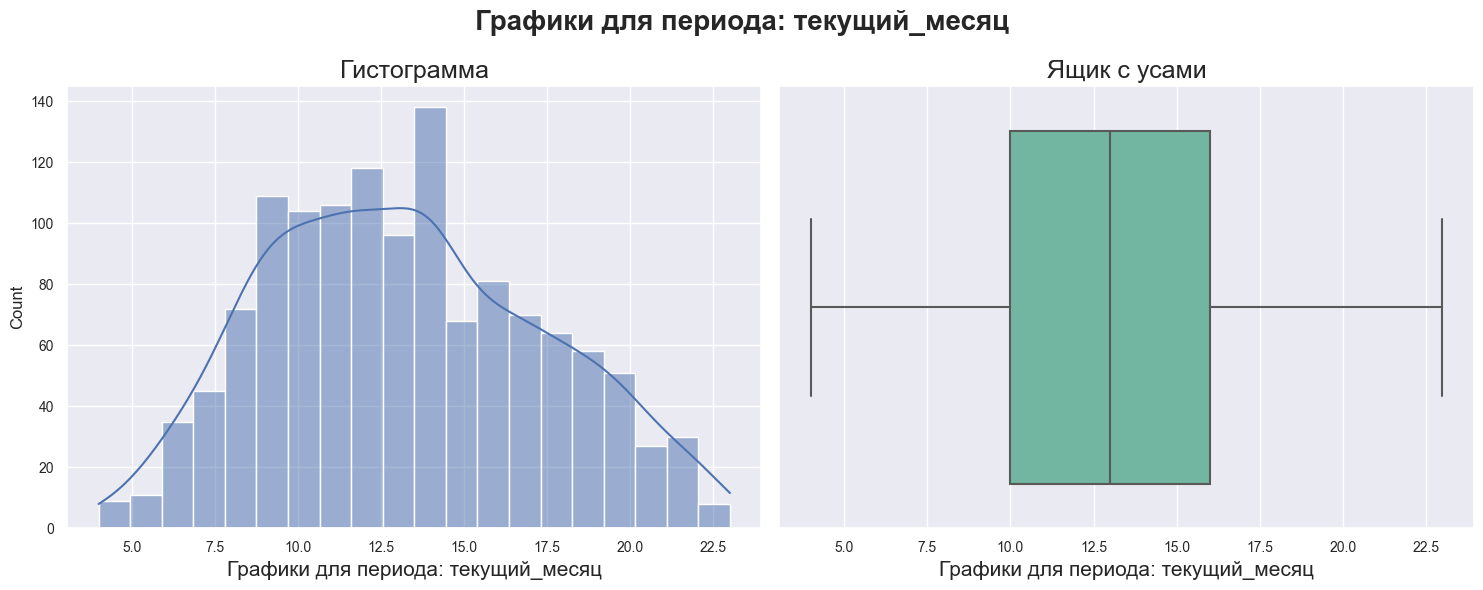

count   1,300.000
mean       13.205
std         4.221
min         4.000
25%        10.000
50%        13.000
75%        16.000
max        23.000
Name: минут, dtype: float64


In [36]:
grouped = time.groupby('период')['минут'].sum().reset_index()

for period in grouped['период'].unique():
    period_data = time[time['период'] == period]
    quantitative_attributes(period_data, 'минут', f'Графики для периода: {period}')

Оба периода очень похожи друг на друга, максимальные, средние и минимальные значения приблизительно равны. ОТличаются распределения. В предыдущем месяце существует разрыв между 13 и 14,5 минутами - никто не провел на сайте указанное количество минут. В предыдущем месяце распределение больше похоже на нормальное и имеет пик на 14 минутах.

Значения времени распределены нормально, среднее и медианное время проведенное на сайте равно 13 минутам, максимальное 23.

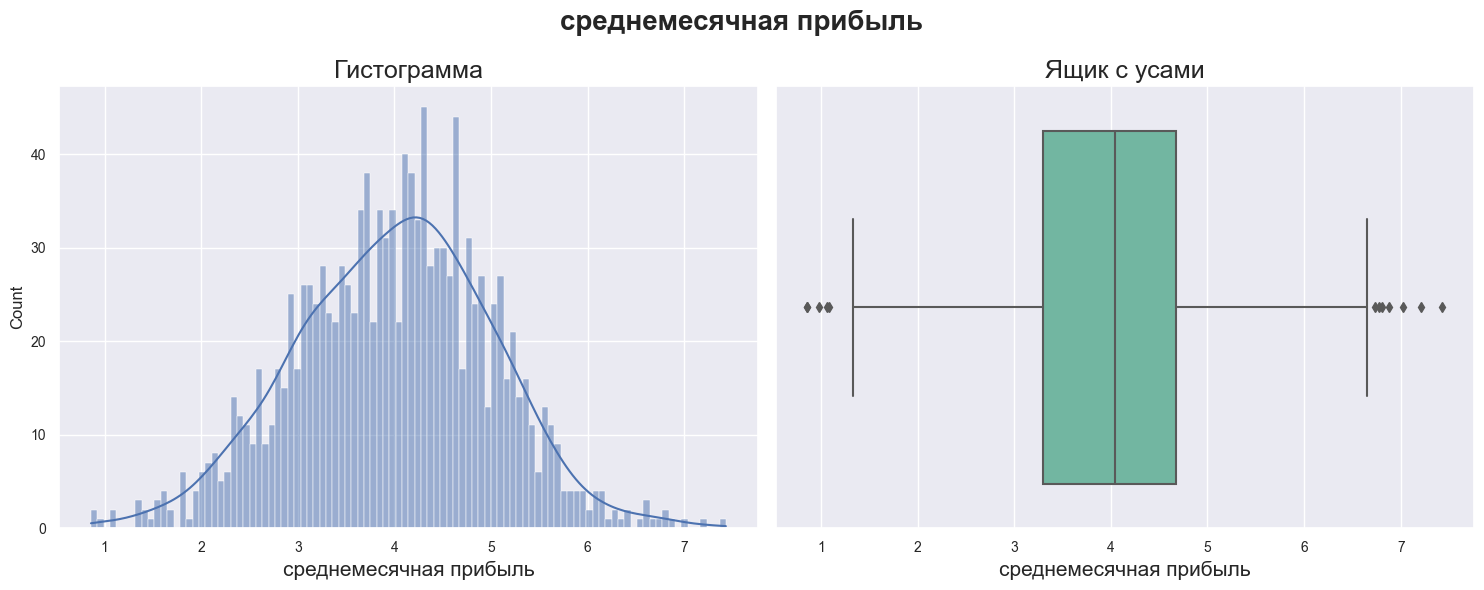

count   1,300.000
mean        3.997
std         1.014
min         0.860
25%         3.300
50%         4.045
75%         4.670
max         7.430
Name: прибыль, dtype: float64


In [37]:
quantitative_attributes(money,'прибыль','cреднемесячная прибыль', bins=100)

Среднемесячная прибыль распределена нормально, среднее значение и медианное равны 4.

#### 3.2. Отбор клиентов с покупательской активностью не менее 3-х месяцев

Отфильтруем по выручке клиентов.

In [38]:
non_zero = m_money[m_money['выручка'] > 0]

active_clients = non_zero.groupby('id')['период'].nunique()
active_clients = active_clients[active_clients == 3].index

consumer_activity = file[file['id'].isin(active_clients)]

print(display(consumer_activity.head(5)))
consumer_activity.info()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
1,215349,Снизилась,премиум,да,4.400,4,819,0.750,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.900,3,539,0.140,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.200,5,896,0.990,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.100,3,1064,0.940,Товары для детей,3,2,3,2
5,215353,Снизилась,стандарт,да,3.300,4,762,0.260,Домашний текстиль,4,1,1,4


None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1296 non-null   int64   
 1   покупательская_активность            1296 non-null   category
 2   тип_сервиса                          1296 non-null   category
 3   разрешить_сообщать                   1296 non-null   category
 4   маркет_актив_6_мес                   1296 non-null   float64 
 5   маркет_актив_тек_мес                 1296 non-null   int64   
 6   длительность                         1296 non-null   int64   
 7   акционные_покупки                    1296 non-null   float64 
 8   популярная_категория                 1296 non-null   category
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64   
 11  ошибка_серви

Получили новый датофрейм `consumer_activity` состоящий из 1296 строк и 13 колонок, с информацией о клиентах имеющих покупательскую активность 3 месяца и более.

#### Промежуточный вывод

**Цель:** провести исследовательский анализ данных, отобрать клиентов с высокой покупательской активностью.  
**Задачи:**
1. Провести статистический анализ данных.
2. Отобрать клиентов с высокой покупательской активностью.

**Результаты**

1) Провести статистический анализ данных:
- При исследовании категориальных данных выявилось, что покупательская активность снизилась у 38,3% покупателей. Данные о периодах выручки и прибили распределены равнозначно.
- Имеются выбросы в количественных столбце `Выручка` датафрейма `m_money`. Выбросы удалены.
- Среднее и медиана у всех количественных признаков слабо отличались друг от друга.

2) Отобрать клиентов с высокой покупательской активностью:
- Создан новый датафрейм `customer_activity` состоящий из 1296 строк и 13 колонок с информацией о клиентах с покупательской активностью не менее 3-х месяцев.

# Шаг 4

#### 4.1. Объединение таблиц

In [39]:
combined = non_zero.merge(time, on=['id', 'период'], how='outer')

r_pivot = combined.pivot_table(
    index='id', 
    columns='период', 
    values='выручка', 
    aggfunc='sum', 
    fill_value=0
).reset_index()

t_pivot = combined.pivot_table(
    index='id', 
    columns='период', 
    values='минут', 
    aggfunc='sum', 
    fill_value=0
).reset_index()

market = r_pivot.merge(file, on='id', how='left').merge(t_pivot, on='id', how='left')
market = market.rename(columns={
    'предыдущий_месяц_x': 'предыдущий_месяц_выручка',
    'препредыдущий_месяц_x': 'препредыдущий_месяц_выручка',
    'текущий_месяц_x': 'текущий_месяц_выручка',
    'предыдущий_месяц_y': 'предыдущий_месяц_минут',
    'текущий_месяц_y': 'текущий_месяц_минут'
})
revenue_columns = ['предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка']
market =  market[(market[revenue_columns] > 0).all(axis=1)]
market = market.drop(columns=['препредыдущий_месяц_y'])
print(display(market.head(5)))
market.info()

,id,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_минут,текущий_месяц_минут
1,215349,"5,216.000",4472,"4,971.600",Снизилась,премиум,да,4.400,4,819,0.750,Товары для детей,4,4,2,5,12,10
2,215350,"5,457.500",4826,"5,058.400",Снизилась,стандарт,нет,4.900,3,539,0.140,Домашний текстиль,5,2,1,5,8,13
3,215351,"6,158.000",4793,"6,610.400",Снизилась,стандарт,да,3.200,5,896,0.990,Товары для детей,5,0,6,4,11,13
4,215352,"5,807.500",4594,"5,872.500",Снизилась,стандарт,нет,5.100,3,1064,0.940,Товары для детей,3,2,3,2,8,11
5,215353,"4,738.500",5124,"5,388.500",Снизилась,стандарт,да,3.300,4,762,0.260,Домашний текстиль,4,1,1,4,10,10


None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1296 non-null   int64   
 1   предыдущий_месяц_выручка             1296 non-null   float64 
 2   препредыдущий_месяц_выручка          1296 non-null   int64   
 3   текущий_месяц_выручка                1296 non-null   float64 
 4   покупательская_активность            1296 non-null   category
 5   тип_сервиса                          1296 non-null   category
 6   разрешить_сообщать                   1296 non-null   category
 7   маркет_актив_6_мес                   1296 non-null   float64 
 8   маркет_актив_тек_мес                 1296 non-null   int64   
 9   длительность                         1296 non-null   int64   
 10  акционные_покупки                    1296 non-null   float64 
 11  популярная_к

#### Промежуточный вывод

**Цель:** Объединить таблицы.  
**Задачи:**
1. Объединить таблицы.
2. Разделить столбцы.

**Результаты**

1) Объединить таблицы:
- Объединены датафреймы `file`, `m_money`, `time` в новый датафрейм `market` состящий из 1296 строк и 18 столбцов.

2) Разделить столбцы:
- Созданы новые столбцы разделяющие разные период времени и выручки. 


# Шаг 5

#### 5.1. Корреляционный анализ

In [40]:
market.columns

Index(['id', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка',
       'текущий_месяц_выручка', 'покупательская_активность', 'тип_сервиса',
       'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес',
       'длительность', 'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'предыдущий_месяц_минут', 'текущий_месяц_минут'],
      dtype='object')

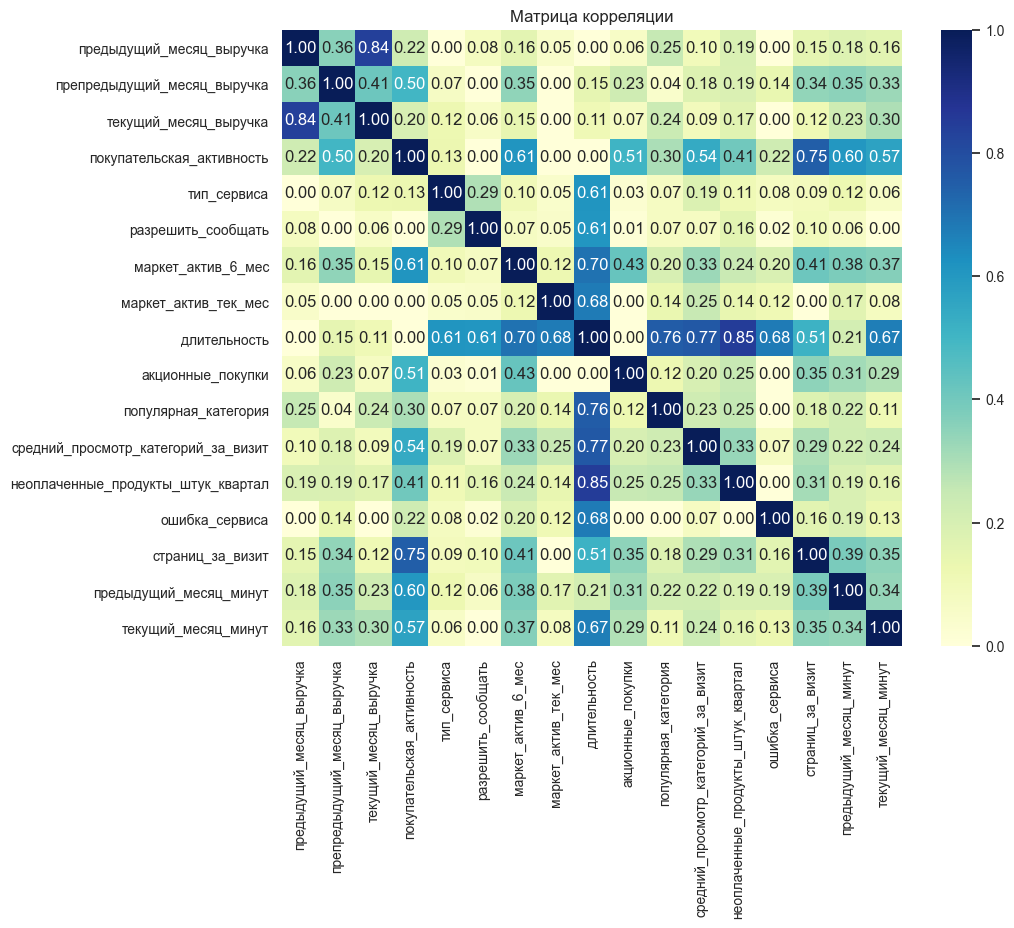

In [41]:
interval_cols = ['предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка', 
                    'акционные_покупки']
corr_market = market.set_index('id')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_market.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Матрица корреляции')
plt.show()

Мультиколлинеарность отсутсвует. Предыдущий месяц выручки сильно коррелирует с предпредыдущим месяцем выручки, текущим месяцем и акционными покупками. Целевой признак имеет сильную взаимосвязь с признаками страниц за визит и умеренную корреляцию с признаками длительности посещения страниц за последние два месяца, с неоплаченными продуктами в квартал, просмотр категорий за визит, акционные покупки, маркетинговая активность 6 мес и препредыдущий месяц выручка.

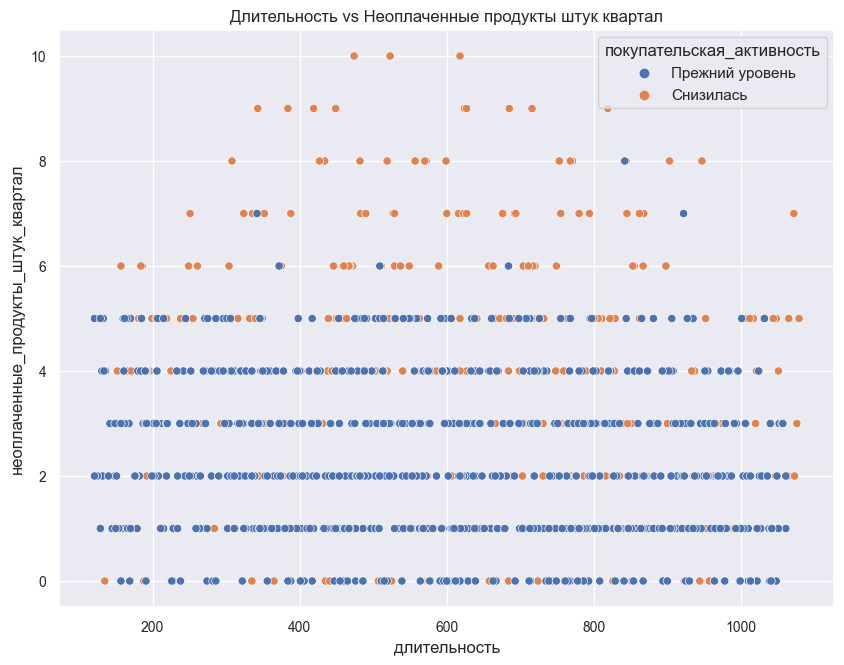

In [42]:
sns.scatterplot(
    data=market, 
    x='длительность', 
    y='неоплаченные_продукты_штук_квартал', 
    hue='покупательская_активность'
)
plt.title('Длительность vs Неоплаченные продукты штук квартал')
plt.show()

Выявлена сильная зависимость на грани с мультиколлинеарностью у признаков `длительность` и `неоплаченные_продукты_штук_квартал`. 

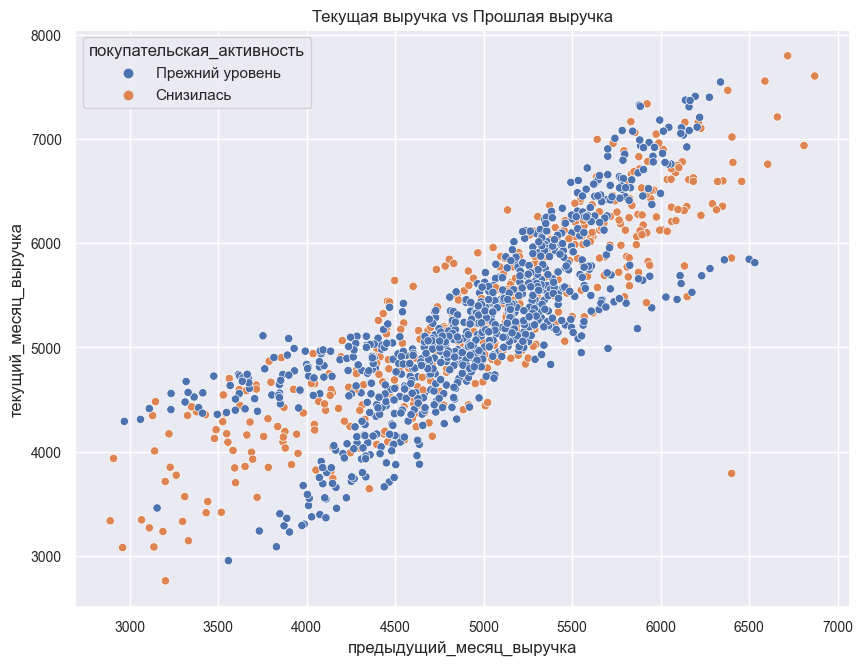

In [43]:
sns.scatterplot(
    data=market, 
    x='предыдущий_месяц_выручка', 
    y='текущий_месяц_выручка', 
    hue='покупательская_активность'
)
plt.title('Текущая выручка vs Прошлая выручка')
plt.show()

У выручек за данный и прошлый месяц сильная зависимость, на графике видно, что прямая расщепляется на две или одну широкую прямую у покупателей с преждним уровнем покупательской активности.

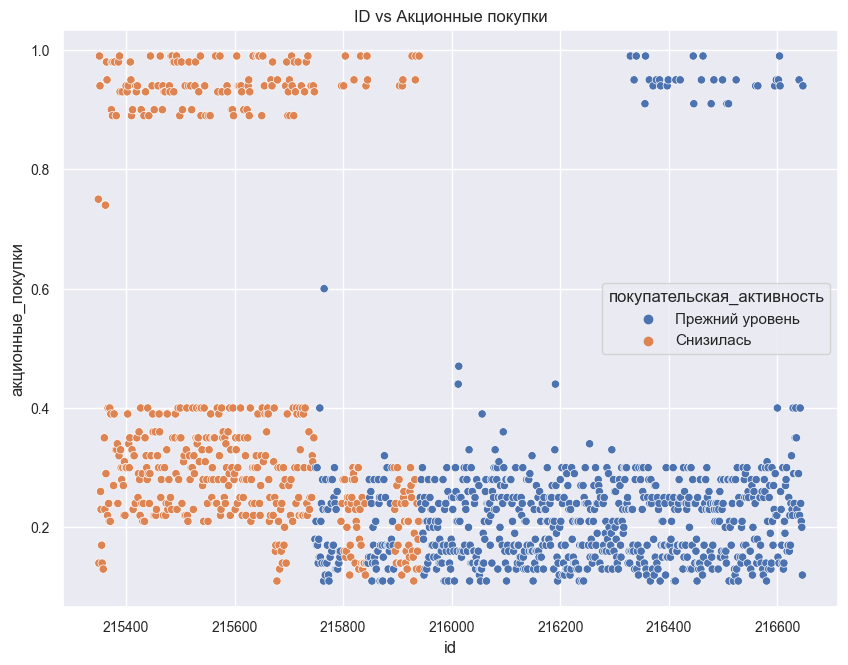

In [44]:
sns.scatterplot(
    data=market, 
    x='id', 
    y='акционные_покупки', 
    hue='покупательская_активность'
)
plt.title('ID vs Акционные покупки')
plt.show()

Старые клиенты (id меньше 216000) явно ориентированы на акционные покупки (оранжевые точки с долей 1.0), что могло привести к снижению их общей активности. У клиентов с прежним уровнем активности акционные покупки часто не занимают большую долю. Возможно, что такое поведение у более новых клиентов временно и спустя время повтроится картина, как у "старых" клиентов. Возможно такое распределение связано с какими-либо изменениями в магазине - смена условий доставки заказов, смена ассортимента и т.д.

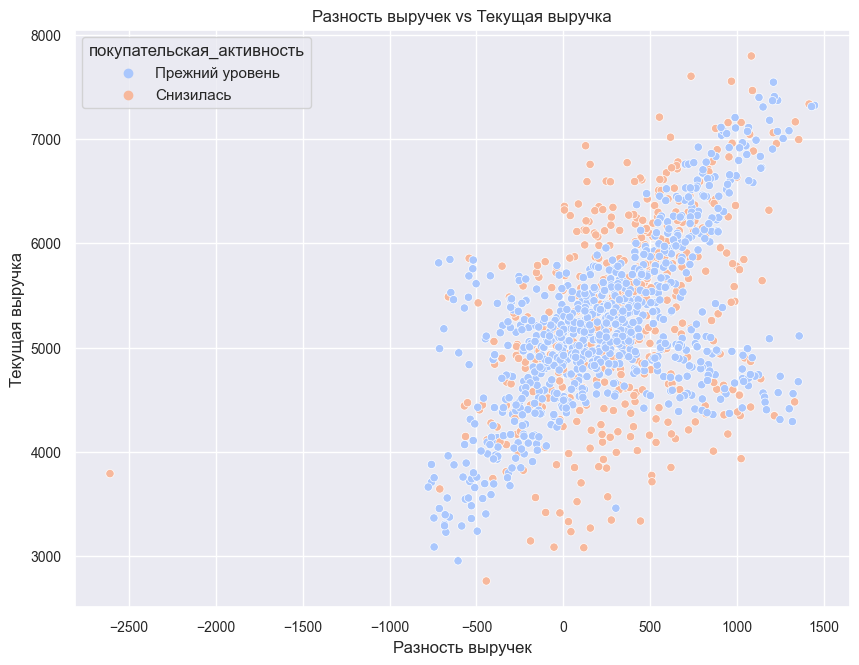

In [45]:
market['разность_выручек'] = market['текущий_месяц_выручка'] - market['предыдущий_месяц_выручка']

sns.scatterplot(
    data=market,
    x='разность_выручек', 
    y='текущий_месяц_выручка',  
    hue='покупательская_активность',  
    palette='coolwarm'
)
plt.title('Разность выручек vs Текущая выручка')
plt.xlabel('Разность выручек')
plt.ylabel('Текущая выручка')
plt.show()

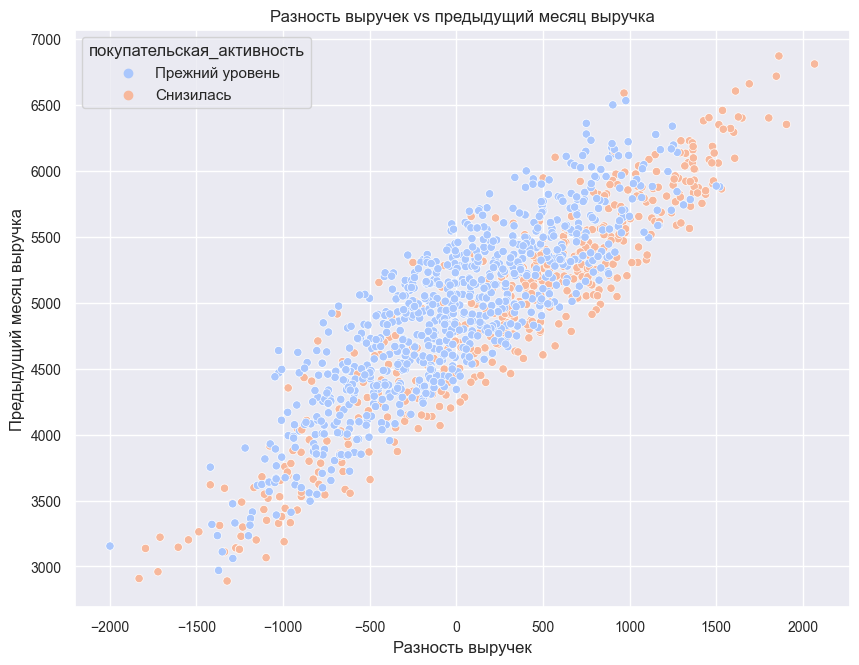

In [46]:
market['разность_выручек'] = market['предыдущий_месяц_выручка'] - market['препредыдущий_месяц_выручка']

sns.scatterplot(
    data=market,
    x='разность_выручек', 
    y='предыдущий_месяц_выручка',  
    hue='покупательская_активность',  
    palette='coolwarm'
)
plt.title('Разность выручек vs предыдущий месяц выручка')
plt.xlabel('Разность выручек')
plt.ylabel('Предыдущий месяц выручка')
plt.show()

Разница выручек между препредыдущим месяцем и предыдущим  и предыдущим и текущим:
- разница выручек препредыдущего месяца и предыдущего от -2000 до 2000
- разница выручек предыдущего месяца и текущего от -1000 до 1500
- разница выручек препредыдущего месяца и предыдущего имеет прямую зависимость, чего нельзя сказать так уверено о разнице между предыдущим месяцем и текущим
- группы клиентов с "прежним уровнем" активности проявляют большую стабильность в выручках, а клиенты со "снижением" активности могут быть чувствительны к внешним факторам, что усиливает разброс в данных

#### Промежуточный вывод

**Цель:** провести корреляционный анализ признаков.  
**Задачи:**
1. Выявить корреляцию.
2. Выявить мультиколлинеарность.

**Результаты**

1) Выявить корреляцию: 
- Для расчета корреляции применялся коэффициент Фи так как среди признаков имелись категориальные. Выявлена сильная положительная зависимость между целевым признаком `Покупательская_активность` и `страниц_за_визит`, так же целевой признак умеренно коррелирует с многими другими признаками, такими как `Акционные_покупки`, `Маркетинговая_активность_6_мес` и прочие.

2) Выявить мультиколлинеарность:
- Мультиколлинеарность не выявлена. Вносить изменения нет необходимости.
- Проведено дополнительное исследование зависимостей признаков.

# Шаг 6

#### 6.1. Создание пайплайнов

Первым делом создадим списки для кодирования и масштабирования данных. Делим выборку, чтобы избежать утечки данных. Уточним, что у нас имеется дисбаланс классов целевого признака "Покупательская активность". Во время исследовательского анализа было установлено, что **снизилась** покупательская активность у 38.3% пользователей, на **прежнем уровне** у 61.7% пользователей. Используем кодирование целевого признака Label Encoder.

In [47]:
ohe_columns = [
    'популярная_категория', 
    'разрешить_сообщать'
]
ord_columns = [
    'тип_сервиса'
]
ss_columns = [ 'маркет_актив_6_мес',
               'средний_просмотр_категорий_за_визит',
               'ошибка_сервиса',
               'страниц_за_визит',
               'предыдущий_месяц_минут'
]
mm_columns = ['предыдущий_месяц_выручка',
               'препредыдущий_месяц_выручка',
               'длительность',
               'акционные_покупки',
               'неоплаченные_продукты_штук_квартал'
]

In [48]:
encoder = LabelEncoder()
X = corr_market.drop(['покупательская_активность'], axis=1)
y = encoder.fit_transform(corr_market['покупательская_активность'])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(972, 16)
(324, 16)
(972,)
(324,)


Уточним как LabelEncoder закодировал признаки. Это потребуется в дальнейшем для подсчета метрик.

In [49]:
original_labels = encoder.inverse_transform([0, 1])

print(f"Значение для 0: {original_labels[0]}")
print(f"Значение для 1: {original_labels[1]}")

Значение для 0: Прежний уровень
Значение для 1: Снизилась


Создаем пайплайны. Для масштабирования количественных признаков используем **MinMaxScaler** и **StandardScaler**, для кодирования категориальных **OneHotEncoder** и **OrdinalEncoder**.

In [50]:
scalers = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler()
}

encoders = {
    'ohe': OneHotEncoder(drop='first', handle_unknown='error'),
    'ord': OrdinalEncoder()
}

num_standard = Pipeline([
    ('scaler', scalers['standard'])
])

num_minmax = Pipeline([
    ('scaler', scalers['minmax'])
])

cat_ohe= Pipeline([
    ('encoder', encoders['ohe'])
])

cat_ord = Pipeline([
    ('encoder', encoders['ord'])
])

data_preprocessor = ColumnTransformer([
    ('num_standard', num_standard, ss_columns),
    ('num_minmax', num_minmax, mm_columns),
    ('cat_ohe', cat_ohe, ohe_columns),
    ('cat_ord', cat_ord, ord_columns)
],
    remainder='drop'
)

#### 6.2. Обучение моделей

Создаем единый пайплайн `final_pipe` в котором заключены 4 модели. **KNeighborsClassifier** c гиперпараметрами - количество ближайших соседей и мера дистанции. **DecisionTreeClassifier** c гиперпараметрами - минимальное количество образцов, необходимое для нахождения в листовом узле каждого дерева, минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться, максимальную глубина дерева. **LogisticRegression** c гиперпараметрами - ридж-регуляризация по умолчанию и настройка С-коэффициент. **SVC** c гиперпараметрами - так же С-коэффициент, настройка ядра. Так как в нашей выборке дисбаланс классов то для моделей **SVC** и **LogisticRegression** применим взвешивание классов.   
**Выбор метрики.** Перед нами задача для бинарной классификации. Так как задача звучит как "построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца", то оценку лучшей модели будем проводить по метрике ROC-AUC так как данная метрика оценивает способность модели различать классы на всех возможных порогах классификации и не чувствительна к дисбалансу классов. При работе модели с тестовыми данными учитывем ROC-AUC и F1 совместно, чтобы понять, насколько точно модель предсказывает положительные примеры.

In [51]:
def create_final_pipe(data_preprocessor):
    return {
        'KNeighborsClassifier': {
            'model': Pipeline([('preprocessor', data_preprocessor),
                               ('classifier', KNeighborsClassifier())]),
            'params': {
                'classifier__n_neighbors': optuna.distributions.IntDistribution(1, 200),
                'classifier__metric': optuna.distributions.CategoricalDistribution(['euclidean', 'manhattan'])
            }
        },
        'DecisionTreeClassifier': {
            'model': Pipeline([('preprocessor', data_preprocessor),
                               ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))]),
            'params': {
                'classifier__min_samples_leaf': optuna.distributions.IntDistribution(1, 10),
                'classifier__min_samples_split': optuna.distributions.IntDistribution(2, 10),
                'classifier__max_depth': optuna.distributions.IntDistribution(2, 10)
            }
        },
         'LogisticRegression': {
             'model': Pipeline([('preprocessor', data_preprocessor),
                                ('classifier', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced'))]),
             'params': {
                 'classifier__C': optuna.distributions.FloatDistribution(0.01, 10),
                 'classifier__penalty': optuna.distributions.CategoricalDistribution(['l1', 'l2']),
                 'classifier__solver': optuna.distributions.CategoricalDistribution(['saga'])
             }
        },
        'SVC': {
            'model': Pipeline([('preprocessor', data_preprocessor),
                               ('classifier', SVC(probability=True, class_weight='balanced'))]),
            'params': {
                'classifier__C': optuna.distributions.FloatDistribution(0.01, 10),
                'classifier__kernel': optuna.distributions.CategoricalDistribution(['linear', 'sigmoid', 'rbf'])
                }
        },
        # Добавляем RidgeRegression
        'RidgeRegression': {
            'model': Pipeline([('preprocessor', data_preprocessor),
                               ('classifier', Ridge())]),
            'params': {
                'classifier__alpha': optuna.distributions.FloatDistribution(0.01, 10)
            }
        }
    }

def train_best_model(X_train, y_train, final_pipe):
    best_model = None
    best_score = 0
    best_model_name = ""
    best_model_params = {}
    roc_auc_scorer = 'roc_auc'
    

    for model_name, model_info in final_pipe.items():
        optuna_search = OptunaSearchCV(
            estimator=model_info['model'],
            param_distributions=model_info['params'],
            cv=5,
            n_trials=100,
            random_state=RANDOM_STATE,
            scoring=roc_auc_scorer,
            refit=True
        )
        optuna_search.fit(X_train, y_train)
            
        score = optuna_search.best_score_
        print(f"Значение ROC-AUC у модели {model_name}: {score:.4f} (параметры: {optuna_search.best_params_})")
        if score > best_score:
            best_score = score
            best_model = optuna_search.best_estimator_
            best_model_name = model_name
            best_model_params = optuna_search.best_params_

    print(f"\nЛучшей моделью является {best_model_name} с параметрами: {best_model_params} и ROC-AUC: {best_score:.4f}\n")
    return best_model, best_score, best_model_name, best_model_params

def get_model_probabilities(model, X_test):
    return model.predict_proba(X_test)[:, 1]

def evaluate_model(model, best_score, X_test, y_test, best_model_name, best_model_params):
    print(f"Значение ROC-AUC на обучающих данных: {best_score:.4f}")
    print(f"\nЛучшей моделью является {best_model_name} с параметрами: {best_model_params} и ROC-AUC: {best_score:.4f}\n")

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    test_roc_auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f'Значение ROC-AUC на тестовых данных: {test_roc_auc_score:.4f}')

    y_pred = (y_pred_proba >= 0.5).astype(int)
    f1_score_value = f1_score(y_test, y_pred, pos_label=1)
    print(f"Значение F1 на тестовых данных: {f1_score_value:.4f}")

def main(X_train, y_train, X_test, y_test, data_preprocessor):
    final_pipe = create_final_pipe(data_preprocessor)
    best_model, best_score, best_model_name, best_model_params = train_best_model(X_train, y_train, final_pipe)
    evaluate_model(best_model, best_score, X_test, y_test, best_model_name, best_model_params)
    return best_model

In [52]:
%%time
model = main(X_train, y_train, X_test, y_test, data_preprocessor)

/var/folders/5f/nv81v5t14yz6vbmzb9bm5ntm0000gn/T/ipykernel_8690/1717131665.py:56: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2025-03-12 17:38:07,837] A new study created in memory with name: no-name-6ae0604f-931a-4346-b153-d28bfbc348eb
[I 2025-03-12 17:38:07,987] Trial 0 finished with value: 0.8770229568411387 and parameters: {'classifier__n_neighbors': 91, 'classifier__metric': 'euclidean'}. Best is trial 0 with value: 0.8770229568411387.
[I 2025-03-12 17:38:08,131] Trial 1 finished with value: 0.8831274973320428 and parameters: {'classifier__n_neighbors': 64, 'classifier__metric': 'euclidean'}. Best is trial 1 with value: 0.8831274973320428.
[I 2025-03-12 17:38:08,266] Trial 2 finished with value: 0.8875097337006428 and parameters: {'classifier__n_neighbors': 43, 'classifier__metric': 'manhattan'}. Best is trial 2 with value: 0.8875097337006428.
[I 2025-03-12 17:38:08,400] 

Значение ROC-AUC у модели KNeighborsClassifier: 0.8929 (параметры: {'classifier__n_neighbors': 109, 'classifier__metric': 'manhattan'})


[I 2025-03-12 17:38:21,640] Trial 1 finished with value: 0.839426200580746 and parameters: {'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 6, 'classifier__max_depth': 4}. Best is trial 1 with value: 0.839426200580746.
[I 2025-03-12 17:38:21,751] Trial 2 finished with value: 0.8234959136822771 and parameters: {'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 3, 'classifier__max_depth': 3}. Best is trial 1 with value: 0.839426200580746.
[I 2025-03-12 17:38:21,870] Trial 3 finished with value: 0.8532360012905468 and parameters: {'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5, 'classifier__max_depth': 10}. Best is trial 3 with value: 0.8532360012905468.
[I 2025-03-12 17:38:21,978] Trial 4 finished with value: 0.8430950797905343 and parameters: {'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 4, 'classifier__max_depth': 5}. Best is trial 3 with value: 0.8532360012905468.
[I 2025-03-12 17:38:22,091] Trial 5 fi

Значение ROC-AUC у модели DecisionTreeClassifier: 0.8726 (параметры: {'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 5, 'classifier__max_depth': 8})


[I 2025-03-12 17:38:34,434] Trial 1 finished with value: 0.8954023850296577 and parameters: {'classifier__C': 3.201278037887276, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}. Best is trial 0 with value: 0.8955362047998412.
[I 2025-03-12 17:38:34,570] Trial 2 finished with value: 0.8953979649070559 and parameters: {'classifier__C': 2.1321384771823033, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}. Best is trial 0 with value: 0.8955362047998412.
[I 2025-03-12 17:38:34,705] Trial 3 finished with value: 0.8955995085995084 and parameters: {'classifier__C': 3.1922669797871515, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}. Best is trial 3 with value: 0.8955995085995084.
[I 2025-03-12 17:38:34,845] Trial 4 finished with value: 0.8954671183580276 and parameters: {'classifier__C': 5.071779296096319, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}. Best is trial 3 with value: 0.8955995085995084.
[I 2025-03-12 17:38:34,982] Trial 5 finished with 

Значение ROC-AUC у модели LogisticRegression: 0.8959 (параметры: {'classifier__C': 6.17076609342095, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'})


[I 2025-03-12 17:38:49,291] Trial 0 finished with value: 0.8925939071302708 and parameters: {'classifier__C': 4.552463511691507, 'classifier__kernel': 'linear'}. Best is trial 0 with value: 0.8925939071302708.
[I 2025-03-12 17:38:49,987] Trial 1 finished with value: 0.8924821954185591 and parameters: {'classifier__C': 4.857020057829874, 'classifier__kernel': 'linear'}. Best is trial 0 with value: 0.8925939071302708.
[I 2025-03-12 17:38:50,548] Trial 2 finished with value: 0.8951421611694339 and parameters: {'classifier__C': 1.77045085298536, 'classifier__kernel': 'rbf'}. Best is trial 2 with value: 0.8951421611694339.
[I 2025-03-12 17:38:51,111] Trial 3 finished with value: 0.8894727942818852 and parameters: {'classifier__C': 5.071779296096319, 'classifier__kernel': 'rbf'}. Best is trial 2 with value: 0.8951421611694339.
[I 2025-03-12 17:38:52,080] Trial 4 finished with value: 0.8924373365100638 and parameters: {'classifier__C': 8.571109621056534, 'classifier__kernel': 'linear'}. Best 

Значение ROC-AUC у модели SVC: 0.8953 (параметры: {'classifier__C': 0.9339813696867006, 'classifier__kernel': 'rbf'})


[I 2025-03-12 17:39:44,543] Trial 1 finished with value: 0.8939677487969686 and parameters: {'classifier__alpha': 8.327994002826447}. Best is trial 0 with value: 0.8945534133755102.
[I 2025-03-12 17:39:44,644] Trial 2 finished with value: 0.8954415841788335 and parameters: {'classifier__alpha': 0.699822895327306}. Best is trial 2 with value: 0.8954415841788335.
[I 2025-03-12 17:39:44,745] Trial 3 finished with value: 0.8950044177212055 and parameters: {'classifier__alpha': 3.201278037887276}. Best is trial 2 with value: 0.8954415841788335.
[I 2025-03-12 17:39:44,848] Trial 4 finished with value: 0.8946192953146472 and parameters: {'classifier__alpha': 4.857020057829874}. Best is trial 2 with value: 0.8954415841788335.
[I 2025-03-12 17:39:44,950] Trial 5 finished with value: 0.8950507028280315 and parameters: {'classifier__alpha': 2.989633697337656}. Best is trial 2 with value: 0.8954415841788335.
[I 2025-03-12 17:39:45,052] Trial 6 finished with value: 0.8951222862968959 and parameters

Значение ROC-AUC у модели RidgeRegression: 0.8956 (параметры: {'classifier__alpha': 1.0783325919579063})

Лучшей моделью является LogisticRegression с параметрами: {'classifier__C': 6.17076609342095, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'} и ROC-AUC: 0.8959

Значение ROC-AUC на обучающих данных: 0.8959

Лучшей моделью является LogisticRegression с параметрами: {'classifier__C': 6.17076609342095, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'} и ROC-AUC: 0.8959

Значение ROC-AUC на тестовых данных: 0.9153
Значение F1 на тестовых данных: 0.8395
CPU times: user 2min 12s, sys: 13 s, total: 2min 25s
Wall time: 1min 47s


- Значение **ROC-AUC** у модели **KNeighborsClassifier: 0.8929** (параметры: {'classifier__n_neighbors': 99, 'classifier__metric': 'manhattan'}))
- Значение **ROC-AUC** у модели **DecisionTreeClassifier: 0.8726** (параметры: {'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 4, 'classifier__max_depth': 5})
- Значение **ROC-AUC** у модели **LogisticRegression: 0.8959** (параметры: {'classifier__C': 6.17076609342095, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'})
- Значение **ROC-AUC** у модели  **SVC: 0.8953**  параметры: {'classifier__C': 0.9339813696867003, 'classifier__kernel': 'rbf'})
- Значение **ROC-AUC** у модели **RidgeRegression: 0.8956** параметры: ({'classifier__alpha': 1.0783325919579063})

Следовательно:  
Значение F1 у лучшей модели LogisticRegression: 0.8395    
Значение ROC-AUC у лучшей модели  LogisticRegression: 0.8959

Значение ROC-AUC на тестовых данных 0.9153

Оптимальной моделью для данной задачи является метод логистической регрессии с ридж-регуляризацией.

#### 6.3. Выбор лучшей модели

Построим график ROC кривой для предсказанных значений и определим наилучший порог классификации по F1.

Лучший порог по F1 на обучающих данных: 0.50 с F1: 0.8124


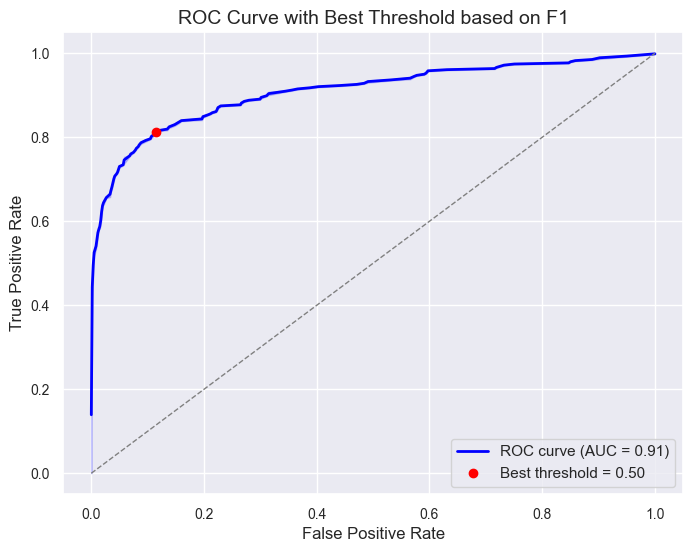

In [53]:
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba_train)
roc_auc = roc_auc_score(y_train, y_pred_proba_train)

thresholds_f1 = np.arange(0.0, 1.05, 0.05)

best_threshold = 0.5
best_f1 = 0

for threshold in thresholds_f1:
    y_pred_train = (y_pred_proba_train >= threshold).astype(int)
    current_f1 = f1_score(y_train, y_pred_train, pos_label=1)
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f"Лучший порог по F1 на обучающих данных: {best_threshold:.2f} с F1: {best_f1:.4f}")

index_best_threshold = np.argmin(np.abs(thresholds - best_threshold))

fpr_best = fpr[index_best_threshold]
tpr_best = tpr[index_best_threshold]

plt.figure(figsize=(8, 6))

sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue', linewidth=2)
sns.lineplot(x=[0, 1], y=[0, 1], color='gray', linestyle='--', linewidth=1)

plt.scatter(fpr_best, tpr_best, color='red', label=f'Best threshold = {best_threshold:.2f}', zorder=5)

plt.title('ROC Curve with Best Threshold based on F1', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')

plt.show()

Наилучшим значением порога для выбранной модели будет порог классификации равный 0.50. При таком пороге полнота и точность модели определяемые метрикой F1 будет равны 0.81. 

In [54]:
y_pred_proba = model.predict_proba(X)[:, 1]  
y_pred = (y_pred_proba >= 0.50).astype(int) 
y_pred_decoded = encoder.inverse_transform(y_pred)
corr_market['предсказание_ПА'] = y_pred_decoded
print(display(corr_market.query('`предсказание_ПА` == "Снизилась"')))

,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_минут,текущий_месяц_минут,предсказание_ПА
id,,,,,,,,,,,,,,,,,,
215349,"5,216.000",4472,"4,971.600",Снизилась,премиум,да,4.400,4,819,0.750,Товары для детей,4,4,2,5,12,10,Снизилась
215350,"5,457.500",4826,"5,058.400",Снизилась,стандарт,нет,4.900,3,539,0.140,Домашний текстиль,5,2,1,5,8,13,Снизилась
215351,"6,158.000",4793,"6,610.400",Снизилась,стандарт,да,3.200,5,896,0.990,Товары для детей,5,0,6,4,11,13,Снизилась
215352,"5,807.500",4594,"5,872.500",Снизилась,стандарт,нет,5.100,3,1064,0.940,Товары для детей,3,2,3,2,8,11,Снизилась
215353,"4,738.500",5124,"5,388.500",Снизилась,стандарт,да,3.300,4,762,0.260,Домашний текстиль,4,1,1,4,10,10,Снизилась
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216634,"2,970.000",4342,"4,289.500",Прежний уровень,стандарт,да,4.100,4,335,0.400,Техника для красоты и здоровья,3,4,3,7,14,13,Снизилась
216635,"4,452.000",4980,"5,039.600",Прежний уровень,стандарт,да,0.900,3,932,0.350,Косметика и аксессуары,3,3,8,5,12,18,Снизилась
216636,"5,644.500",4860,"6,454.400",Прежний уровень,премиум,да,2.400,4,996,0.230,Кухонная посуда,3,4,5,6,10,14,Снизилась


None


На тестовой выборке получили 490 клиентов у которых снизится покупательская активность.

#### Промежуточный вывод

**Цель:** Выбрать лучшую модель при помощи пайплайнов.  
**Задачи:**
1. Создать пайплайны.
2. Обучить модели.
3. Выбрать лучшую модель.

**Результаты**

1) Создать пайплайны: 
- Создан пайплайн `scalers` для кодирования количественных признаков при помощи MinMaxScaler и StandardScaler.
- Создан пайплайн `encoders` для кодирования категориальных признаков при помощи OneHotEncoder и OrdinalEncoder.

2) Обучить модели:
- С помощью единого пайплайна `final_pipe` обучено четыре модели, подбор гиперпараметров осуществлен с помощью OptunaSearchCV.
- Модели оценены метрикой ROC-AUC, у итоговой модели еще метрика F1.
- Лучшая модель по метрике ROC-AUC имеет значение 0.8959.

3) Выбрать лучшую модель:
- Лучшая модель это метод логистической регрессии с ридж-регуляризацией.
- Определили оптимальный порог классификации модели в 0.50 при котором метрика F1 будет равна 0.81.
- Получили предсказание о 490 клиентах у которых снизится покупательская активность.

# Шаг 7

#### 7.1. Оценка важности признаков лучшей модели

Проведем оценку того, как каждый признак помог предсказать значение целевого с помощью значений Шепли. 

Построим столбчатую диаграмму для оценки общего вклада признаков в прогнозы модели. Beeswarm для визуализации вклада признаков в каждое предсказание модели.

In [55]:
pip install scikit-learn==0.24.2

Note: you may need to restart the kernel to use updated packages.


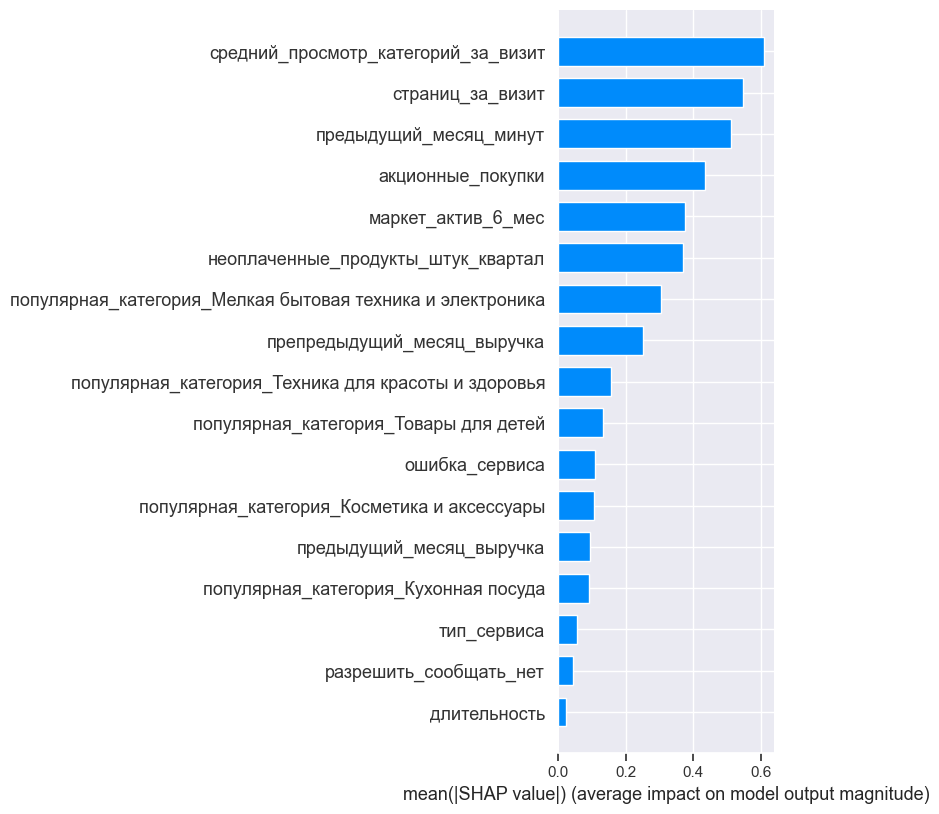

In [56]:
X_train_preprocessed = data_preprocessor.fit_transform(X_train)
X_test_preprocessed = data_preprocessor.transform(X_test)

cat_ohe_pipeline = data_preprocessor.named_transformers_['cat_ohe']
ohe_encoder = cat_ohe_pipeline.named_steps['encoder']

if hasattr(ohe_encoder, 'get_feature_names_out'):
    ohe_feature_names = ohe_encoder.get_feature_names_out(input_features=ohe_columns)
else:
    ohe_feature_names = ohe_encoder.get_feature_names(input_features=ohe_columns)

ord_feature_names = ord_columns  
ss_feature_names = ss_columns  
mm_feature_names = mm_columns  

all_feature_names = np.concatenate([ss_feature_names, mm_feature_names, ohe_feature_names, ord_feature_names])

X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

classifier = model.named_steps['classifier']
classifier.fit(X_train_preprocessed_df.values, y_train)

explainer = shap.LinearExplainer(classifier, X_train_preprocessed_df.values)
shap_values = explainer.shap_values(X_test_preprocessed_df.values)

feature_names = X_test_preprocessed_df.columns.tolist()
shap.summary_plot(shap_values, features=X_test_preprocessed_df, feature_names=feature_names, plot_type="bar")

In [57]:
shap_values_class_1_subset = explainer.shap_values(X_test_preprocessed_df.values)
shap.summary_plot(shap_\\values_class_1_subset, 
                  X_test_preprocessed_df, 
                  feature_names=all_feature_names, 
                  plot_size=(10, 6)) 

SyntaxError: unexpected character after line continuation character (2199264772.py, line 2)

In [ ]:
shap_values_array = shap_values_class_1_subset
shap_importance = np.abs(shap_values_array).mean(axis=0)

shap_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'SHAP Importance': shap_importance
})

shap_importance_df = shap_importance_df.sort_values(by='SHAP Importance', ascending=False)
(shap_importance_df)

#### 7.2. Анализ графиков

Анализ показал, что высокие значения среднего просмотра категорий за визит, количества страниц за визит и времени, проведённого на сайте в предыдущем месяце, свидетельствуют о низкой вероятности снижения покупательской активности. Это указывает на устойчивый интерес клиентов к продуктам и услугам компании.

В то же время высокая доля акционных покупок может сигнализировать о высокой вероятности снижения покупательской активности. Это может означать, что покупатели ориентированы преимущественно на скидки и менее лояльны к бренду вне периодов распродаж.

Для поддержания стабильного уровня покупательской активности ключевую роль играет маркетинговая активность. Эффективные кампании и персонализированные предложения способны стимулировать интерес и укрепить лояльность клиентов.

Наименее значимыми факторами оказались длительность пользования сервисом и тип подписки, что может свидетельствовать о слабой зависимости покупательского поведения от этих характеристик. Это открывает возможности для более гибкой работы с различными сегментами клиентов без фокусировки на сроке их обслуживания или тарифных планах.

#### Промежуточный вывод

**Цель:** Проанализировать важность признаков.  
**Задачи:**
1. Построить график важности SHAP.
2. Проанализировать графики.

**Результаты**

1) Построить график важности SHAP: 
- Построена столбчатая диаграмма для оценки общего вклада признаков в прогнозы модели. 
- График Beeswarm для визуализации вклада признаков в каждое предсказание модели.

2) Проанализировать графики:
- Наибольшее влияние на модель оказывают признаки: средний_просмотр_категорий_за_визит, страниц_за_визит, предыдущий_месяц_минут, акционные_покупки, маркет_актив_6_мес.
- Модель не придаёт значительного значения признакам: тип_сервиса, разрешить_сообщать_нет, длительность.
- Высокая покупательская активность связана с интересом к контенту и маркетингом, тогда как зависимость от акций снижает лояльность, а длительность использования сервиса и тип подписки мало влияют на поведение клиентов.

# Шаг 8

#### 8.1. Сегментация покупателей

Объединим датафрейм `corr_market` с результами предсказания и `money`. 

In [ ]:
final_df = corr_market.merge(money, on='id', how='left')
print(final_df.info(),display(final_df.head(5)))

1296 строк 18 столбцов.

In [ ]:
final_df['прибыль'].describe()

Добавим в датафрейм столбец о категории полученной среднемесячной прибыли полученной от клиента за последние 3 месяца.  
* Высокий доход - Прибыль от 5.5 до 7.5
* Средний доход - Прибыль от 3 до 5.5
* Низкий доход - Прибыль от 0 до 3

In [ ]:
def categorize_income(profit):
    if 5.5 <= profit <= 7.5:
        return 'Высокий доход'
    elif 3 <= profit < 5.5:
        return 'Средний доход'
    elif 0 <= profit < 3:
        return 'Низкий доход'

final_df['доход_категория'] = final_df['прибыль'].apply(categorize_income)

final_df.head()

In [ ]:
categorical_attributes(final_df, 'доход_категория', 'Доход категория')

77% клиентов относятся к категории Средний доход.

#### 8.2. Предложение для увеличения пользовательской активности

Возьмем для исследования сегмент покупателей от которой интернет-магазин имеет высокий доход и которым модель предсказала снижение покупательской активности и у которых тип сервиса Премиум.

In [ ]:
segment = final_df.query('`доход_категория` == "Высокий доход" & `предсказание_ПА` == "Снизилась" & `тип_сервиса` == "премиум"')
print(display(segment.head()), segment.info())

Таких клиентов всего 10 человек.

Мы уже выделили во время обучения одели значения Шепли. Исследуем отличие нашего сегмента от основной массы пользователей по топ-3 важным признакам - средний_просмотр_категорий_за_визит, страниц_за_визит, предыдущий_месяц_минут.

In [ ]:
# Выделим остальных пользователей
other_clients = final_df[~final_df.index.isin(segment.index)]
print(display(other_clients.head(), other_clients.info()))

Получили 1286 оставшихся покупателя. В нашем сегменте 10 покупателей. Проведем графическое и аналитическое исследование данной группы покупателей.

In [ ]:
segment_stats = segment.describe()
overall_stats = other_clients.describe()

diff = segment_stats.loc['mean'] - overall_stats.loc['mean'] 
print(diff.sort_values(ascending=False))

Ожидаемо клиенты исследуемого сегмента имеют высокую выручку. Так же они являются более "старыми" клиентами сайта. У них более высокая маректинговая активность и они чуть больше совершают акционных покупок. Они меньше посещают страниц за визит (что, как выяснилось является признаком стабильности покупательской активности) и они еньше проводят времени на сайте.

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(segment['длительность'], label='Сегмент', shade=True)
sns.kdeplot(other_clients['длительность'], label='Остальные клиенты', shade=True)
plt.title('Распределение длительность')
plt.xlabel('Длительность')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Клиенты исследуемого сегмента являются более давними клиентами данного интернет-магазина.

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(segment['страниц_за_визит'], label='Сегмент', shade=True)
sns.kdeplot(other_clients['страниц_за_визит'], label='Остальные клиенты', shade=True)
plt.title('Распределение Страниц за визит')
plt.xlabel('Страниц за визит')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Покупатели нашего сегмента посещают за визит меньше почти в 2 раза страниц за визит.

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(segment['маркет_актив_6_мес'], label='Сегмент', shade=True)
sns.kdeplot(other_clients['маркет_актив_6_мес'], label='Остальные клиенты', shade=True)
plt.title('Распределение Маркет актив 6 мес')
plt.xlabel('Маркет актив 6 мес')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Видно, что маркетинговая актиность выше у остальных клиентов, возможно, стоит обратить на это внимание.

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(segment['акционные_покупки'], label='Сегмент', shade=True)
sns.kdeplot(other_clients['акционные_покупки'], label='Остальные клиенты', shade=True)
plt.title('Распределение акционные покупки')
plt.xlabel('Акционные покупки')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Пики одинаковые, плотность у остальных клиентов выше за счет большего количества людей. Распределения одинаковые.

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(segment['средний_просмотр_категорий_за_визит'], label='Сегмент', shade=True)
sns.kdeplot(other_clients['средний_просмотр_категорий_за_визит'], label='Остальные клиенты', shade=True)
plt.title('Распределение Средний_просмотр_категорий_за_визит')
plt.xlabel('Средний_просмотр_категорий_за_визит')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Покупатели нашего сегмента совершают меньше просмотров категорий за визит.

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(segment['неоплаченные_продукты_штук_квартал'], label='Сегмент', shade=True)
sns.kdeplot(other_clients['неоплаченные_продукты_штук_квартал'], label='Остальные клиенты', shade=True)
plt.title('Распределение Неоплаченные_продукты_штук_квартал')
plt.xlabel('Неоплаченные_продукты_штук_квартал')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Покупатели нашего сегмента больше товаров сохраняют в корзине неоплаченными.

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=segment, x='предыдущий_месяц_минут', label='Сегмент', shade=True)
sns.kdeplot(data=other_clients, x='предыдущий_месяц_минут', label='Остальные клиенты', shade=True)
plt.title('Распределение времени на сайте за предыдущий месяц')
plt.xlabel('Время на сайте (минуты)')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Покупатели нашего сегмента проводят почти в два раза меньше времени на сайте.

In [ ]:
categorical_attributes(segment, 'популярная_категория', 'Популярная категория')

Самая востребованная категория у исследуемого сегмента - товары для детей.

In [ ]:
categorical_attributes(other_clients, 'популярная_категория', 'Популярная категория')

У остальных покупателей популярной категорией является тоже товары для детей, но еще и домашний текстиль.

In [ ]:
sns.pairplot(other_clients, vars=['маркет_актив_6_мес', 'средний_просмотр_категорий_за_визит', 'прибыль'], hue='предсказание_ПА')
plt.show()

Среди остальных покупателей явно видна разность в маркетинговой активности и предсказанием, чем меньше маркет_актив, тем больше предсказаний о снижении ПА. Так же у среднего просмотра категорий за визит и прибыли.

У нашего сегмента маркетинговая активность относительно высокая, но плохие показатели просмотров за визит.

Выделим проблемы: 
- Клиенты с премиум подпиской, высокой прибылью снижают свою пользовательскую активность.  

Почему? 
- Снижение активности клиентов с премиум-подпиской и высокой выручкой.
- Низкий интерес к просмотру категорий и страниц за визит.
- Высокое количество неоплаченных товаров в корзине.

Решения: 
* Предложить персонализированные рекомендации на основе предыдущих покупок и просмотров категорий.  
* Включить автоматические напоминания о неоплаченных товарах в корзине через email или push-уведомления, предлагая скидку или бесплатную доставку при их покупке.
* Улучшить работу сайта для снижения количества ошибок сервиса.
* Разработать специализированные предложения для премиум-клиентов, такие как эксклюзивные скидки на товары из их популярных категорий.
* Включить сегмент в программы лояльности, предлагая баллы или бонусы за активность на сайте (например, посещение новых категорий).
* Упростить процесс оплаты для уменьшения количества неоплаченных товаров в корзине.

#### 8.3. Выводы о сегментации

Для дополнительного анализа был выбран сегмент покупателей с премиум-подпиской, приносящий высокий доход интернет-магазину, которым модель предсказала снижение покупательской активности. В данный сегмент входят 10 клиентов.

**Отличия сегмента от основной массы покупателей**
1. Высокая выручка: Клиенты исследуемого сегмента обеспечивают значительный доход.
2. Давние клиенты: Эти покупатели пользуются интернет-магазином дольше, чем остальные.
3. Более высокая маркетинговая активность: Они чаще участвуют в акциях и реагируют на маркетинговые рассылки.
4. Меньше посещают страниц за визит: Почти в 2 раза меньше по сравнению с остальными.
5. Меньше времени на сайте: Проводят почти в 2 раза меньше времени за визит.
6. Больше неоплаченных товаров в корзине: Склонны оставлять товары без оформления заказа.
7. Популярная категория: Основной интерес сосредоточен на товарах для детей.

**Проблемы сегмента**
- Снижение активности клиентов с премиум-подпиской и высокой выручкой.
- Низкий интерес к просмотру категорий и страниц за визит.
- Высокое количество неоплаченных товаров в корзине.
- Предложения по повышению покупательской активности
**Индивидуальные предложения и акции:**
Предложить персонализированные скидки на товары из категории "Товары для детей". Эксклюзивные предложения для премиум-клиентов.

Напоминания о брошенных корзинах: автоматические уведомления с напоминаниями и предложением скидки на товары, оставленные в корзине.

Улучшение пользовательского опыта:Оптимизировать интерфейс сайта для быстрой навигации и оформления заказа.

Повышение вовлечённости через контент: Создание тематических подборок товаров и персонализированных рекомендаций. Публикация статей или видео, связанных с товарами для детей.

Эксклюзивный премиум-сервис:Улучшение премиального обслуживания (быстрая доставка, персональный менеджер).

Участие в закрытых распродажах:Организация закрытых мероприятий и распродаж для премиум-клиентов.

#### Промежуточный вывод

**Цель:** Сегментация покупателей.  
**Задачи:**
1. Выполнить сегментацию покупателей.
2. Выбрать группу покупателей и предложить, как увеличить её покупательскую активность.
3. Сделать выводы о сегментах.

**Результаты**

1) Выполнить сегментацию покупателей: 
- Создан датафрейм `final_df` объединением датафрейма `market` с датафреймом `money`: 1300 строк 17 столбцов. 
- Добавлен столбец о категории полученной среднемесячной прибыли полученной от клиента за последние 3 месяца: Высокий доход, Средний доход, Низкий доход.
- 77% клиентов приносят средний доход.

2) Выбрать группу покупателей и предложить, как увеличить её покупательскую активность:
- В датафрейм `segment` отобраны 10 покупателей от которых интернет-магазин имеет высокий доход и которым модель предсказала снижение покупательской активности и у которых тип сервиса Премиум. 
- В датафрейм `other_clients` отобраны все остальные 1286 покупателя.
- Выявили различия между двумя группами покупателей ключевые различия в более низком показателе у выбранного для исследования сегмента показателей прибыль, доход, длительность.
- Предложено: включить автоматические напоминания о неоплаченных товарах в корзине; разработать для премиум клиентов программы лояльности, предлагая баллы или бонусы за активность на сайте и предложения, такие как эксклюзивные скидки на товары из их популярных категорий; упростить процесс оплаты и регистрации.

3) Сделать выводы о сегментах:
- Сегмент взяли для дополнительного исследования из-за снижения покупательской активности среди клиентов приносящих стабильный средний доходом и проявившим интерес к магазину оформив премиум-сервис, что может свидетельствовать о потере интереса, и важно выяснить причины, чтобы удержать таких клиентов.
- Выделены решения: персонализация контента и маркетинга, увеличение маркетинговой активности, оптимизация пользовательского опыта.

# Общий вывод

**Задача:** Задача заключалась в разработке модели, предсказывающей вероятность снижения покупательской активности среди клиентов интернет-магазина "В один клик", а также предложении мер по повышению активности, используя персонализированные предложения.

1) **Исходные данные и предобработка:** 
Данные были собраны из нескольких источников, включая информацию о клиентах, их покупках и маркетинговых активностях. Было обнаружено несколько проблем с разделением чисел с плавающей точкой, а также ошибка в названии столбца.   

**Для предобработки данных были выполнены следующие шаги:**
- Исправлены типы данных (например, приведение категориальных признаков к типу category и столбца "Прибыль" в тип float).
- Обработаны дубликаты, включая исправление неявных дубликатов в столбцах.
- Выявлены выбросы в данных, которые были удалены.

2) **Поиск лучшей модели:** Для предсказания вероятности снижения покупательской активности были использованы различные модели машинного обучения. В результате поиска лучшей модели была выбрана модель метод логистической регрессии с ридж-регуляризацией. Метрика ROC-AUC для этой модели составила 0.8959, что подтверждает её высокую эффективность.

**Лучшая модель:**
Лучшая модель — метод логистической регрессии с ридж-регуляризацией, которая продемонстрировала наилучшие результаты при классификации клиентов. Оптимальный порог классификации был установлен на уровне 0.50, при котором метрика F1 составила 0.81.

3) **Выводы и дополнительные предложения для выбранного сегмента покупателей:**

Для клиентов с премиум-подпиской, у которых модель предсказала снижение активности, рекомендуется:
- Включить напоминания о товарах в корзине, чтобы стимулировать завершение покупок.
- Разработать программы лояльности, предлагая бонусы или скидки для активных пользователей.
- Предложить эксклюзивные скидки на товары из популярных категорий.
- Упростить процесс регистрации и оплаты для повышения удобства покупок.
- Повысить маркетинговую активность, чтобы удержать интерес клиентов и увеличить вовлеченность.  

Таким образом, выявление таких сегментов клиентов позволяет эффективно настроить персонализированные предложения для удержания и повышения их покупательской активности. 


**Дополнительные рекомендации**
Помимо основных рекомендаций есть еще пара идей. Можно создать ограниченные по времени акции или специальные предложения для клиентов из выбранного сегмента, например, эксклюзивные скидки на популярные товары или бесплатная доставка для Премиум клиентов. Специальные предложения и ограниченные акции создают ощущение эксклюзивности и могут стимулировать желание вернуться на сайт и совершить покупку. Наши клиенты как раз любят эксклюзивность раз оформили премиум-сервис. Так же создать или усовершенствовать обратную связь. Предложить клиентам возможность участвовать в опросах или давать отзывы о товарах и сервисе в обмен на бонусы или скидки. 